<center>

<table>
<tr><td>
<img src='./img/optimize.jpg' width='200'>
</td><td>
<img src='./img/sber.jpg' width='400'>
</td><td>
<img src='./img/optimize.jpg' width='200'>
</td></tr>
</table>

</center>


**Авторы материала:** Денис Димитров, Алексей Рябых. Материал можно использовать в любых целях (редактировать, поправлять и брать за основу), но с обязательным упоминанием авторов материала.

# <center>Часть 4. Оптимизация инкассаторских поездок</center>

# План:

1. О задаче оптимизации
    - Методы оптимизации
    - Методы оптимизации (когда множество состояний дискретно): алгоритм имитации отжига, генетический алгоритм
    - Применим к нашей задаче
2. Элементы внутридневной логики + риск-параметры: что можно делать

## Алгоритм имитации отжига (Simulated Annealing)
Более подробно можно посмотреть в статье https://habr.com/ru/post/209610/

Сложность при оптимизации возникает, когда оптимизируемая функция имеет локальные минимумы и максимумы

<img src='./img/sa_hill.png' width='500'>

<img src='./img/sa_desc.png' width='800'>

### Сам алгоритм
<img src='./img/sa_algo.png' width='600'>

### Пример работы
<img src='./img/Hill_Climbing_with_Simulated_Annealing.gif' width='600'>

SA можно решить, например, **замкнутую задачу коммивояжера**: найти кратчайший путь, проходящий через каждый город и заканчивающийся в точке отправления. 
<img src='./img/sa_traveller.png' width='500'>
Как определим фукнцию энергии, минимум которой нам нужно отыскать:
<img src='./img/sa_travel_energy.png' width='800'>
Что было на начальной итерации
<img src='./img/sa_travel_first.png' width='500'>
Что получилось после оптимизации
<img src='./img/sa_travel_last.png' width='500'>

## Применим описанную идею для отыскания оптимального расписания инкассаций

In [1]:
import numpy as np
#np.random.seed(10)

In [2]:
import numpy as np
import pandas as pd
import datetime
import sys
import random
import math
from copy import deepcopy
import OptimizationPack
from OptimizationPack import CashCenter, Optimizer
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 2400)
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# если нужно перезагрузить модуль оптимизации после правок, не роняя ядро
import imp
imp.reload(OptimizationPack)
from OptimizationPack import CashCenter, Optimizer

In [5]:
# from IPython.display  import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
#     if (code_show){
#     $('div.input').hide();
#     } else {
#     $ ('div.input').show();
#     }
#     code_show = !code_show
#     }
#     $( document ).ready(code_toggle);
#     </script>
#     <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Рассмотрим Тверской КИЦ

In [6]:
name_cash_center = 'Тверской'

In [7]:
atm_data = OptimizationPack.atm_data
atm_costs = OptimizationPack.costs

In [8]:
file = open('./data/lecture4/' + name_cash_center + '/0_' + name_cash_center + '.csv')
atm_ids_table = pd.read_csv(file)
file.close()

In [9]:
L_ATM = sorted(set(atm_data.ATM_ID.unique()).intersection(set(atm_ids_table.ATM_ID.unique())))
num_atms = len(L_ATM)
atm_capacity = np.array([30e6 for _ in range(num_atms)])

In [10]:
atm_data=atm_data[atm_data.ATM_ID.isin(L_ATM)]

In [11]:
atm_data.head()

ATM_ID  CLIENT_IN  CLIENT_IN_BEFORE_LOAD  CLIENT_OUT  \
2015-01-01  786314        0.0                    0.0      274800   
2015-01-01  784073        0.0                    0.0           0   
2015-01-01  780262        0.0                    0.0           0   
2015-01-01  780816        0.0                    0.0           0   
2015-01-01  830093        0.0                    0.0        3500   

            CLIENT_OUT_BEFORE_LOAD   CURR  LOAD_IN  LOAD_OUT  INITIAL_BALANCE  
2015-01-01                     0.0  643.0      0.0       0.0         11700600  
2015-01-01                     0.0  643.0      0.0       0.0          1426000  
2015-01-01                     0.0  643.0      0.0       0.0         11987400  
2015-01-01                     0.0  643.0      0.0       0.0          8607000  
2015-01-01                     0.0  643.0      0.0       0.0          9024600

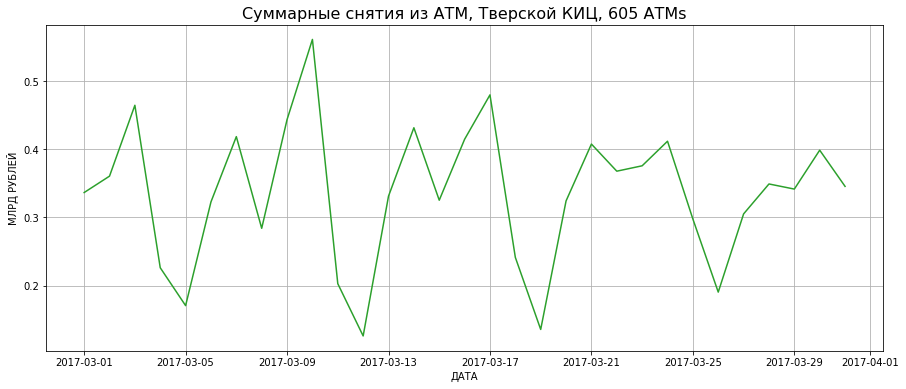

In [12]:
plt.figure(figsize=(15,6))
plt.title('Суммарные снятия из ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(atm_data.groupby(by=atm_data.index)['LOAD_OUT'].sum()['2017-03-01':'2017-03-31'] / 1e9, color='tab:green')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.grid(True)

Построим интересные картинки по зонам

In [13]:
import gmaps
import pandas as pd

gmaps.configure(api_key="")

In [14]:
data_kits = atm_costs[atm_costs.ATM_ID.isin(L_ATM)]

In [15]:
data1 = data_kits[data_kits.NEW_ZONE == 1][['LATITUDE', 'LONGITUDE']]
data2 = data_kits[data_kits.NEW_ZONE == 2][['LATITUDE', 'LONGITUDE']]
data3 = data_kits[data_kits.NEW_ZONE == 3][['LATITUDE', 'LONGITUDE']]
data4 = data_kits[data_kits.NEW_ZONE == 4][['LATITUDE', 'LONGITUDE']]
data5 = data_kits[data_kits.NEW_ZONE == 5][['LATITUDE', 'LONGITUDE']]

data1_layer = gmaps.symbol_layer(
    data1, fill_color="blue",
    stroke_color="blue", scale=2
)

data2_layer = gmaps.symbol_layer(
    data2, fill_color="green",
    stroke_color="green", scale=2,
)

data3_layer = gmaps.symbol_layer(
    data3, fill_color="red",
    stroke_color="red", scale=2
)

data4_layer = gmaps.symbol_layer(
    data4, fill_color="black",
    stroke_color="black", scale=3
)

data5_layer = gmaps.symbol_layer(
    data5, fill_color="purple",
    stroke_color="purple", scale=4
)

In [16]:
fig = gmaps.figure()
fig.add_layer(data1_layer)
fig.add_layer(data2_layer)
fig.add_layer(data3_layer)
fig.add_layer(data4_layer)
fig.add_layer(data5_layer)

In [17]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [18]:
! jupyter nbextension enable --py --sys-prefix gmaps

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py:19: VisibleDeprecationWarning: zmq.eventloop.minitornado is deprecated in pyzmq 14.0 and will be removed.
    Install tornado itself to use zmq with the tornado IOLoop.
    
  from jupyter_client.session import utcnow as now
Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


In [19]:
fig

Figure(layout=FigureLayout(height='420px'))

## <center><span style = "color: blue">Зона 1</span>  --- <span style = "color: green">Зона 2</span> --- <span style = "color: red">Зона 3</span> --- <span style = "color: black">Зона 4</span> --- <span style = "color: purple">Зона 5</span>

### Прогнозы 14-дневные! Это параметр size_window по умолчанию везде далее

In [20]:
global_period = ['2017-03-01', '2017-03-31']
size_window = 14
power = np.array([200 for _ in range(size_window)]) # берем по среднему количеству инкассаций
# OptiCash
priority = {'atm': 1.0}
f_rate = 0.1

In [21]:
n_days = (pd.to_datetime(global_period[1]) - pd.to_datetime(global_period[0])).days + 1

In [22]:
predictions_patriot = []

for num_pr in range(31):
    file_name = './data/lecture4/' + name_cash_center + '/' + str(num_pr) + '_' + name_cash_center + '.csv'
    file = open(file_name)
    forecast_frame = pd.read_csv(file)
    file.close()
    forecast_frame = forecast_frame.rename(columns={forecast_frame.columns[0]: 'DATE'})
    forecast_frame.sort_values(['DATE', 'ATM_ID'], inplace=True)
    dr = forecast_frame.DATE.unique()
    forecast_table = np.zeros(shape=(num_atms,size_window))
    for i_day, day in enumerate(dr):
        forecast_table[:,i_day] = forecast_frame[forecast_frame.DATE == day]['prediction']
    predictions_patriot.append(forecast_table)
    print(file_name)

./data/lecture4/Тверской/0_Тверской.csv
./data/lecture4/Тверской/1_Тверской.csv
./data/lecture4/Тверской/2_Тверской.csv
./data/lecture4/Тверской/3_Тверской.csv
./data/lecture4/Тверской/4_Тверской.csv
./data/lecture4/Тверской/5_Тверской.csv
./data/lecture4/Тверской/6_Тверской.csv
./data/lecture4/Тверской/7_Тверской.csv
./data/lecture4/Тверской/8_Тверской.csv
./data/lecture4/Тверской/9_Тверской.csv
./data/lecture4/Тверской/10_Тверской.csv
./data/lecture4/Тверской/11_Тверской.csv
./data/lecture4/Тверской/12_Тверской.csv
./data/lecture4/Тверской/13_Тверской.csv
./data/lecture4/Тверской/14_Тверской.csv
./data/lecture4/Тверской/15_Тверской.csv
./data/lecture4/Тверской/16_Тверской.csv
./data/lecture4/Тверской/17_Тверской.csv
./data/lecture4/Тверской/18_Тверской.csv
./data/lecture4/Тверской/19_Тверской.csv
./data/lecture4/Тверской/20_Тверской.csv
./data/lecture4/Тверской/21_Тверской.csv
./data/lecture4/Тверской/22_Тверской.csv
./data/lecture4/Тверской/23_Тверской.csv
./data/lecture4/Тверской/2

### Итак, запустим алгоритм оптимизации на тех прогнозах, которые считали выше

In [23]:
fat = 1.2
global_period_extended = pd.date_range(start=global_period[0], end=global_period[1], 
                                       freq = 'D')
num_days = len(global_period_extended)

In [24]:
optimum = []
patriot_raw_downtimes_list = []
patriot_encash_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_load_in_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_encash_hours_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
patriot_losts_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

tmp = np.zeros(num_atms)
for index, ID in enumerate(L_ATM):
    tmp[index] = atm_data[atm_data['ATM_ID'] == ID][global_period[0]:global_period[1]]['INITIAL_BALANCE'].iloc[0]
atm_initial_balances = (np.floor(tmp / 10) * 10).astype('int64')

update_initial_balance = [atm_initial_balances]


for i_day, d1 in enumerate(global_period_extended):
    print([str(d1), str(d1 + datetime.timedelta(size_window-1))])
    
    KITS_slice = CashCenter(atm_ids=L_ATM, 
                            times=[str(d1), str(d1 + datetime.timedelta(size_window-1))], 
                            power=power, 
                            priority=priority, 
                            atm_capacity=atm_capacity, 
                            f_rate=f_rate)
    KITS_slice.set_data()   # криво, потому что приходится две строчки ниже писать
    KITS_slice._atm_initial_balances = update_initial_balance[-1]
    KITS_slice._atm_predictions = (np.ceil(fat * predictions_patriot[i_day] / 10) * 10).astype('int64')
    KITS_slice.set_full_masks()
    KITS_slice.set_state()
    
    opt = Optimizer(KITS_slice)
    optimum.append(opt.optimize(max_iter=3000, num_jump=2))

    patriot_encash_table[:, i_day] = optimum[-1][0][:, 0]
    uploads_hours = KITS_slice.table_upload(optimum[-1][0], timestamp='intraday')
    patriot_load_in_table[:, i_day] = uploads_hours[0][:, 0]
    patriot_encash_hours_table[:, i_day] = uploads_hours[1]
    losts_downtimes = KITS_slice.table_lost(optimum[-1][0], kind='atm', 
                                            facts=True, timestamp ='intraday')
    patriot_losts_table[:, i_day] = losts_downtimes[0][:, 0]
    patriot_raw_downtimes_list.append(losts_downtimes[1])

    update_initial_balance.append(losts_downtimes[0][:, 0])

['2017-03-01 00:00:00', '2017-03-14 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 55.99548292160034
0.8   time = 53.29721283912659
0.7   time = 51.93381190299988
0.6   time = 54.359458923339844
0.5   time = 52.698495864868164
0.4   time = 52.46799087524414
0.3   time = 53.3172390460968
0.2   time = 54.1524658203125
0.1   time = 53.5044960975647
0.0   time = 52.12625598907471


0.9   time = 55.616291999816895
0.8   time = 51.966201066970825
0.7   time = 54.27667188644409
0.6   time = 53.98698306083679
0.5   time = 53.47209811210632
0.4   time = 54.58253622055054
0.3   time = 52.912211894989014
0.2   time = 52.9012770652771
0.1   time = 54.540987968444824
0.0   time = 53.0400230884552


['2017-03-02 00:00:00', '2017-03-15 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was 

0.7   time = 57.430720806121826
0.6   time = 57.578131914138794
0.5   time = 55.635359048843384
0.4   time = 56.147197246551514
0.3   time = 55.280373096466064
0.2   time = 56.233559131622314
0.1   time = 54.96695280075073
0.0   time = 57.47545289993286


0.9   time = 55.22668695449829
0.8   time = 56.31725001335144
0.7   time = 55.058865785598755
0.6   time = 60.61679267883301
0.5   time = 56.007710218429565
0.4   time = 55.6547589302063
0.3   time = 56.586658000946045
0.2   time = 56.162041902542114
0.1   time = 58.836724042892456
0.0   time = 55.89533019065857


['2017-03-07 00:00:00', '2017-03-20 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 58.09635782241821
0.8   time = 56.680381774902344
0.7   time = 56.66718101501465
0.6   time = 58.46867299079895
0.5   time = 57.51237225532532
0.4   time = 55.407716035842896
0.3   time = 52.284790992736816
0.2

There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 52.49915599822998
0.8   time = 49.10469579696655
0.7   time = 50.59200692176819
0.6   time = 49.94593000411987
0.5   time = 51.601568937301636
0.4   time = 49.91344594955444
0.3   time = 51.26255989074707
0.2   time = 50.47119688987732
0.1   time = 51.68079686164856
0.0   time = 51.14374494552612


0.9   time = 51.241233110427856
0.8   time = 51.258583068847656
0.7   time = 52.37757182121277
0.6   time = 50.39228391647339
0.5   time = 51.3335862159729
0.4   time = 50.71020793914795
0.3   time = 50.21084904670715
0.2   time = 51.17477512359619
0.1   time = 49.99133920669556
0.0   time = 51.10858917236328


['2017-03-14 00:00:00', '2017-03-27 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 51.79804587364197
0.8   time = 51.50

0.5   time = 50.79504203796387
0.4   time = 51.395955085754395
0.3   time = 50.89922618865967
0.2   time = 51.33883285522461
0.1   time = 52.068021059036255
0.0   time = 52.30795431137085


['2017-03-22 00:00:00', '2017-04-04 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 50.07000279426575
0.8   time = 51.65851020812988
0.7   time = 51.02862000465393
0.6   time = 51.246209144592285
0.5   time = 51.43923497200012
0.4   time = 52.82917094230652
0.3   time = 51.38462209701538
0.2   time = 50.75138998031616
0.1   time = 51.11985182762146
0.0   time = 51.286423683166504


0.9   time = 51.48471808433533
0.8   time = 51.344537019729614
0.7   time = 52.04482102394104
0.6   time = 50.798763036727905
0.5   time = 51.165255308151245
0.4   time = 50.75519585609436
0.3   time = 52.06188988685608
0.2   time = 51.83568000793457
0.1   time = 52.361496925354004
0.0   ti

0.8   time = 52.07593297958374
0.7   time = 53.02553915977478
0.6   time = 51.613786697387695
0.5   time = 52.46302008628845
0.4   time = 50.366519927978516
0.3   time = 51.32117295265198
0.2   time = 52.48895215988159
0.1   time = 52.53933310508728
0.0   time = 51.623042821884155


['2017-03-30 00:00:00', '2017-04-12 00:00:00']
ATM BLOCK: +
DM BLOCK: -
IPT BLOCK: -
There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms
i_att = 0
0.9   time = 53.75182390213013
0.8   time = 51.862072229385376
0.7   time = 52.643402099609375
0.6   time = 51.88123607635498
0.5   time = 54.1241352558136
0.4   time = 53.23189926147461
0.3   time = 52.8914361000061
0.2   time = 53.1786413192749
0.1   time = 53.71936106681824
0.0   time = 53.56407690048218


0.9   time = 52.669498920440674
0.8   time = 52.07939410209656
0.7   time = 51.44865703582764
0.6   time = 53.643887996673584
0.5   time = 52.263461112976074
0.4   time = 51.90439701080322
0.3   time 

In [25]:
patriot_load_out_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
    
for i_atm, ID in enumerate(L_ATM):
    patriot_load_out_table[i_atm, :] = patriot_load_in_table[i_atm, :] - np.array(atm_data[atm_data['ATM_ID'] == ID]['CLIENT_OUT']['2017-03-01':'2017-03-31']) + np.array(update_initial_balance)[:,i_atm][:-1] - patriot_losts_table[i_atm, :]

patriot_load_out_table = np.where(patriot_load_out_table < 0, 0, patriot_load_out_table)

patriot_funding_costs_table = patriot_losts_table * f_rate / 365
patriot_encash_costs_table = np.zeros(shape=(num_atms, num_days))

for i_atm, ID in enumerate(L_ATM):
    patriot_encash_costs_table[i_atm, :] = patriot_encash_table[i_atm, :] * (atm_costs[atm_costs['ATM_ID'] == ID]['NEW_EXPENSE'].iloc[0] + atm_costs[atm_costs['ATM_ID'] == ID]['NEW_KASSA'].iloc[0])
    
patriot_encash_hours_table = np.where(patriot_encash_hours_table == 24, None, patriot_encash_hours_table)

In [26]:
patriot_downtimes_list = []
for ind in range(len(patriot_raw_downtimes_list)):
    downtimes = deepcopy(patriot_raw_downtimes_list[ind])
    if ind == 0:
        for j in range(len(downtimes)):
            patriot_downtimes_list.append([])
            for k in range(len(downtimes[j])):
                if isinstance(downtimes[j][k], list):
                    patriot_downtimes_list[j].append(downtimes[j][k])
    else:
        for j in range(len(downtimes)):
            for k in range(len(downtimes[j])):
                if isinstance(downtimes[j][k], list):
                    downtimes[j][k][0] = ind
                    patriot_downtimes_list[j].append(downtimes[j][k])

In [27]:
patriot_counts = []
for j in range(len(patriot_downtimes_list)):
    patriot_counts.append(len(patriot_downtimes_list[j]))

### Посмотрим, как все считается сейчас

In [28]:
opticash_load_in_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

for i_atm, ID in enumerate(L_ATM):
    opticash_load_in_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_IN'])

opticash_encash_table = np.where(opticash_load_in_table > 0, 1, 0)

opticash_losts_table = np.zeros(shape=(num_atms, num_days), dtype='int64')
opticash_load_out_table = np.zeros(shape=(num_atms, num_days), dtype='int64')

for i_atm, ID in enumerate(L_ATM):
    opticash_losts_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_IN'] - (atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['CLIENT_OUT']- (atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['INITIAL_BALANCE'] - atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_OUT'])))
    opticash_load_out_table[i_atm, :] = np.array(atm_data[atm_data['ATM_ID'] == ID]['2017-03-01':'2017-03-31']['LOAD_OUT'])

opticash_funding_costs_table = opticash_losts_table * f_rate / 365

opticash_encash_costs_table = np.zeros(shape=(num_atms, num_days))

for i_atm, ID in enumerate(L_ATM):
    opticash_encash_costs_table[i_atm, :] = opticash_encash_table[i_atm, :] * (atm_costs[atm_costs['ATM_ID'] == ID]['NEW_EXPENSE'].iloc[0] + atm_costs[atm_costs['ATM_ID'] == ID]['NEW_KASSA'].iloc[0])

## Построим графики

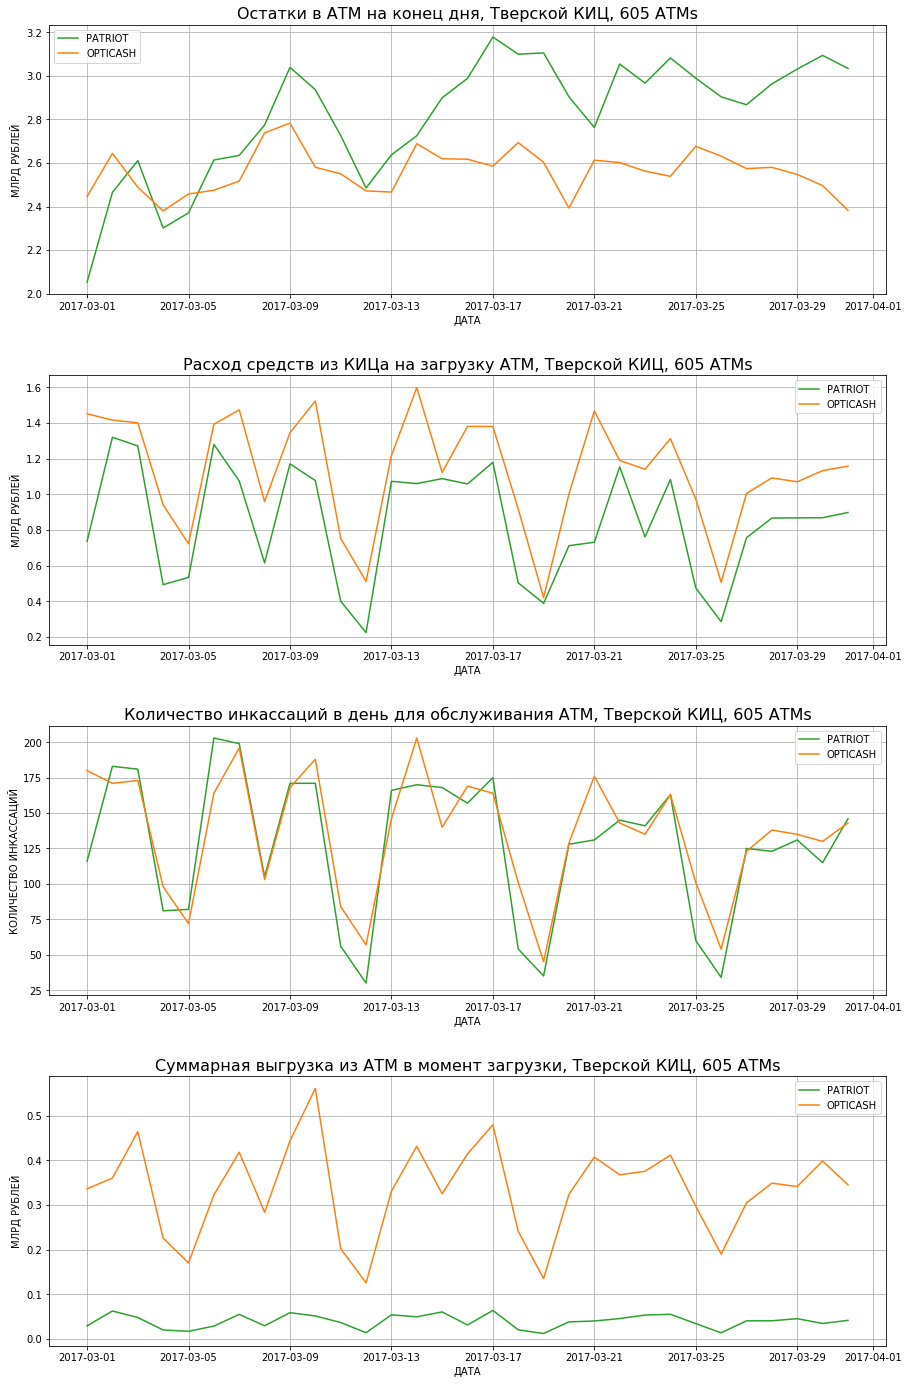

In [29]:
plt.figure(figsize=(15,24.3))
plt.subplots_adjust(hspace=0.3)

plt.subplot(4,1,1)
plt.title('Остатки в ATM на конец дня, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_losts_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_losts_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,2)
plt.title('Расход средств из КИЦа на загрузку ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_load_in_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_load_in_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.title('Количество инкассаций в день для обслуживания ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_encash_table, axis=0), label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_encash_table, axis=0), label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('КОЛИЧЕСТВО ИНКАССАЦИЙ')
plt.legend()
plt.grid(True)

plt.subplot(4,1,4)
plt.title('Суммарная выгрузка из ATM в момент загрузки, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(patriot_load_out_table, axis=0) / 1e9, label='PATRIOT', color='tab:green')
plt.plot(pd.date_range(start='2017-03-01', end='2017-03-31', freq='D'), 
         np.sum(opticash_load_out_table, axis=0) / 1e9, label='OPTICASH', color='tab:orange')
plt.xlabel('ДАТА')
plt.ylabel('МЛРД РУБЛЕЙ')
plt.legend()
plt.grid(True)

plt.show()

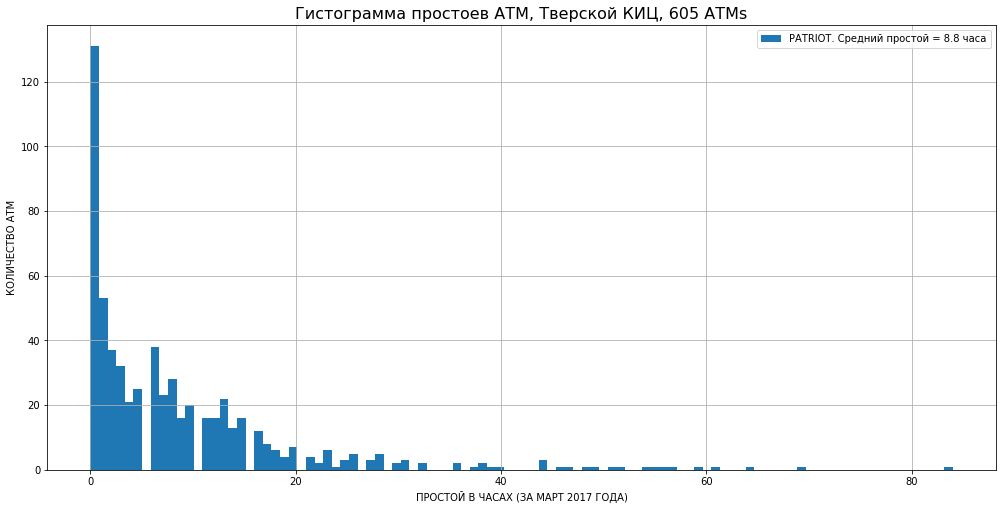

In [30]:
plt.figure(figsize=(17,18))

plt.subplot(2,1,1)
plt.title('Гистограмма простоев ATM, ' + name_cash_center + ' КИЦ, ' + str(len(L_ATM)) + ' ATMs', fontsize=16)
plt.hist(patriot_counts, bins=100, label='PATRIOT. Средний простой = ' + str(np.round(np.mean(patriot_counts), 1)) + ' часа', color='tab:blue')
plt.xlabel('ПРОСТОЙ В ЧАСАХ (ЗА МАРТ 2017 ГОДА)')
plt.ylabel('КОЛИЧЕСТВО ATM')
plt.legend()
plt.grid(True)

plt.show()

### Теперь посмотрим внимательнее, как изменились загрузки для каждого конкретного банкомата

In [31]:
atm_predictions = np.zeros(shape=(num_atms, num_days))
for dd in range(num_days):
    atm_predictions[:,dd] = predictions_patriot[dd][:,0]

atm_facts = np.zeros(shape=(num_atms, num_days))
for index, ID in enumerate(L_ATM):
    atm_facts[index, :] = atm_data[atm_data['ATM_ID'] == ID][global_period[0]:global_period[1]]['CLIENT_OUT']

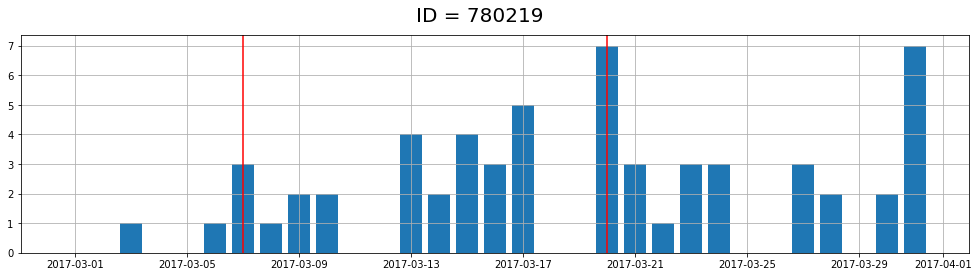

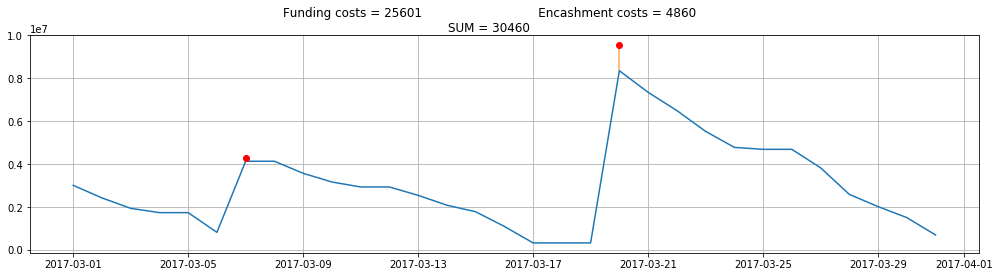

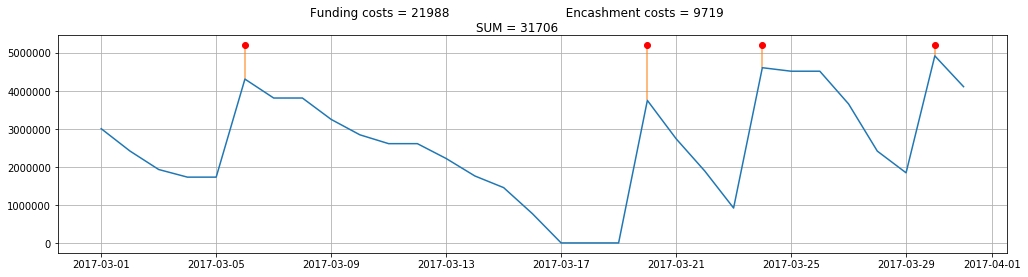

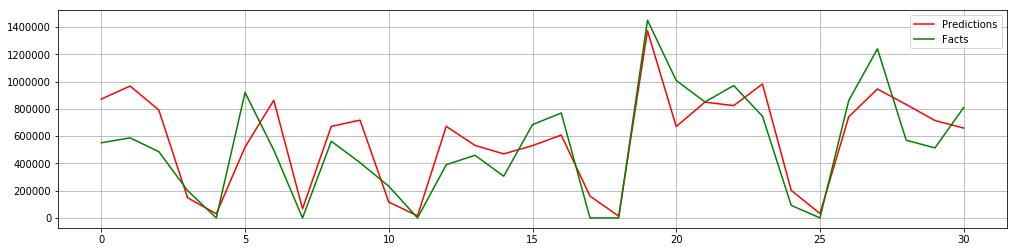

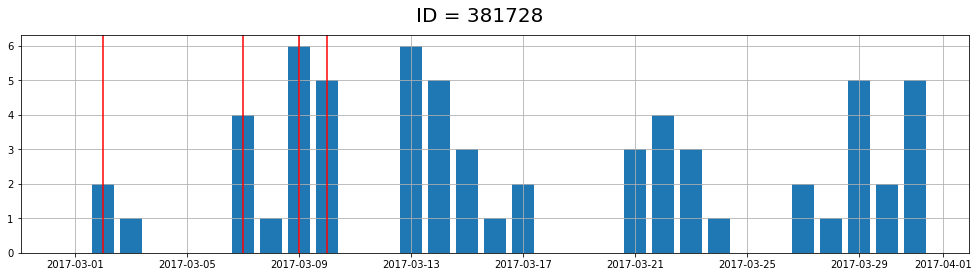

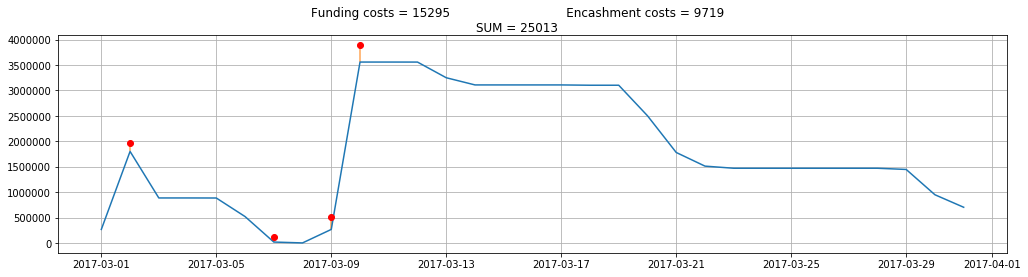

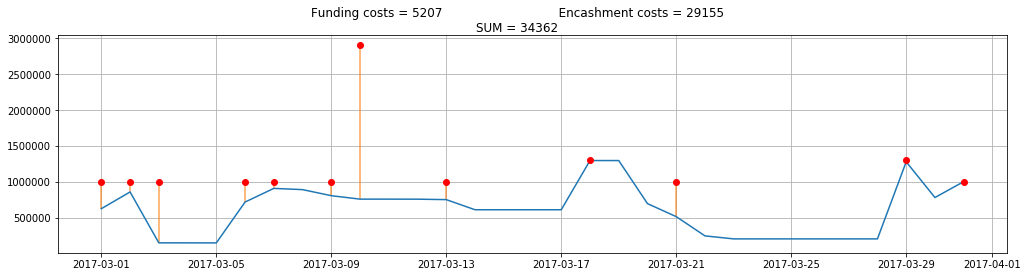

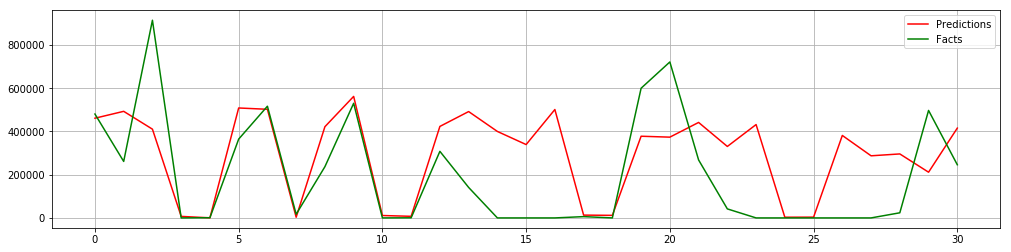

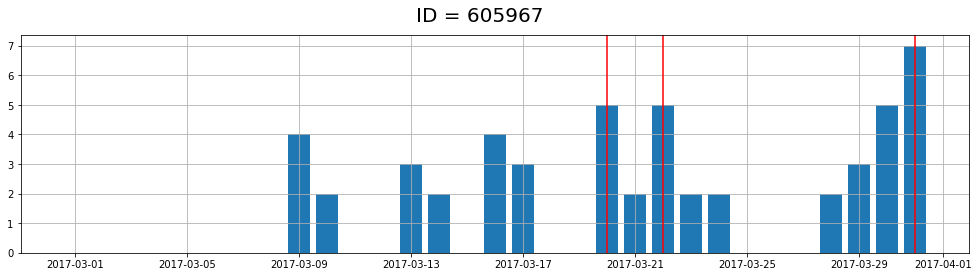

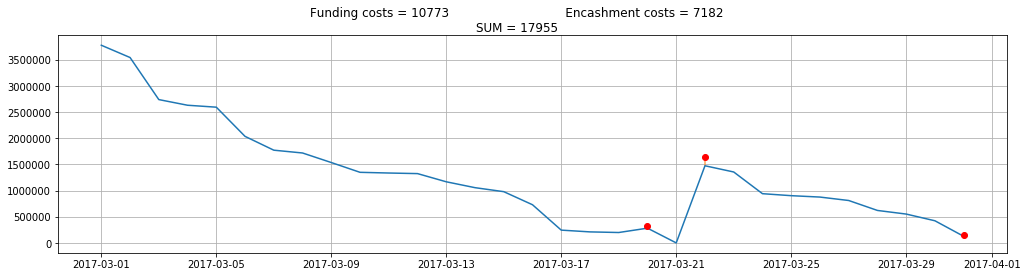

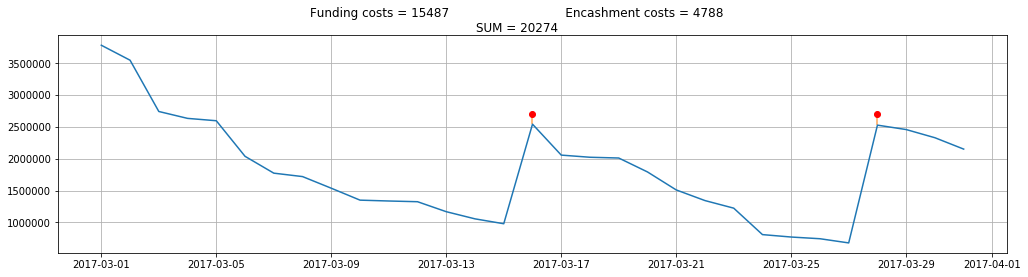

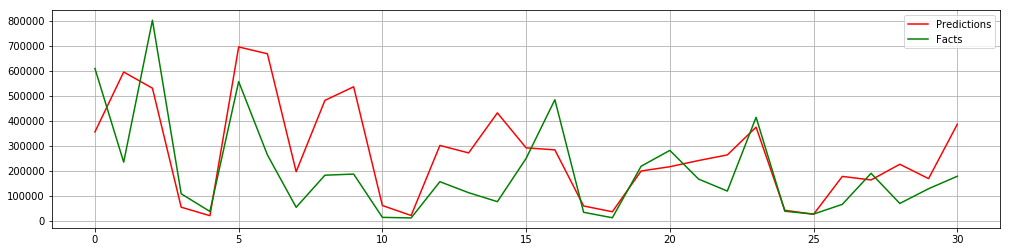

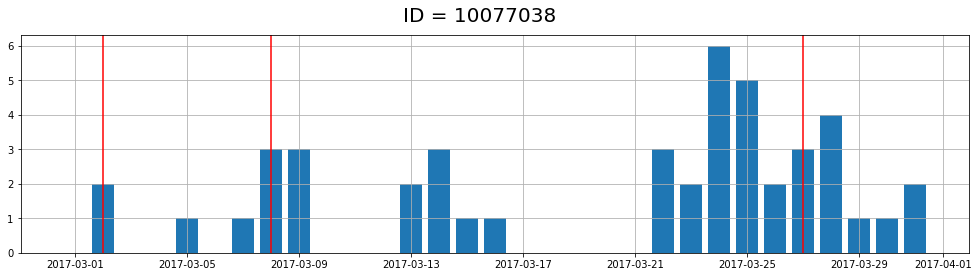

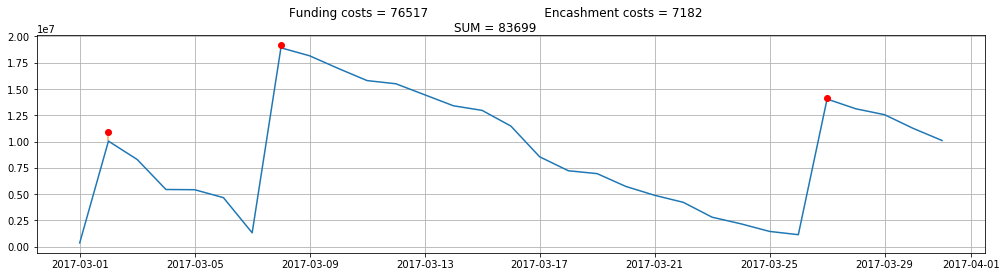

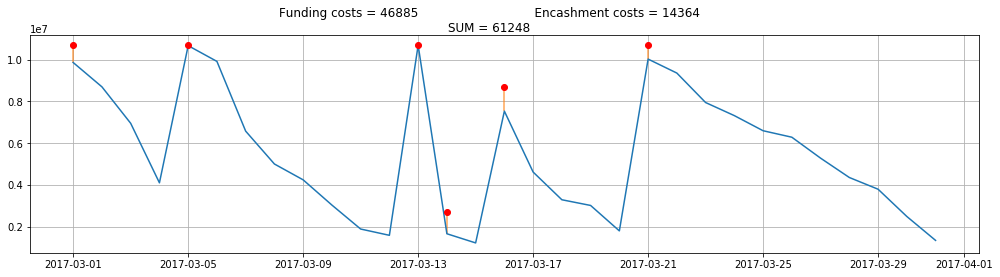

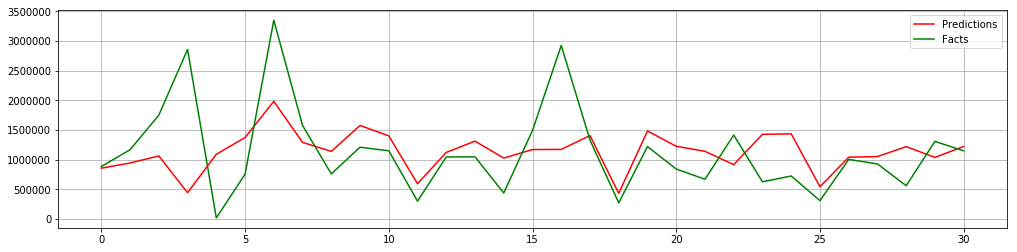

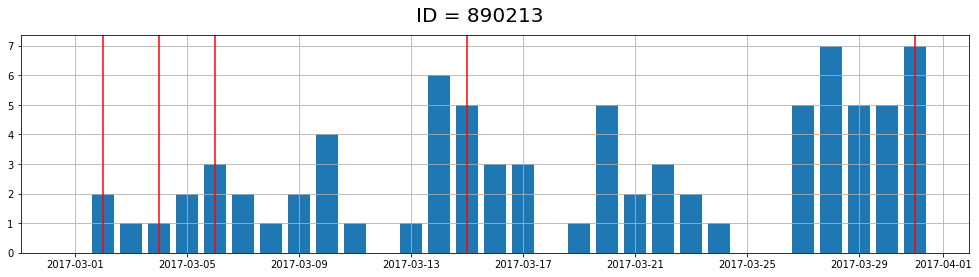

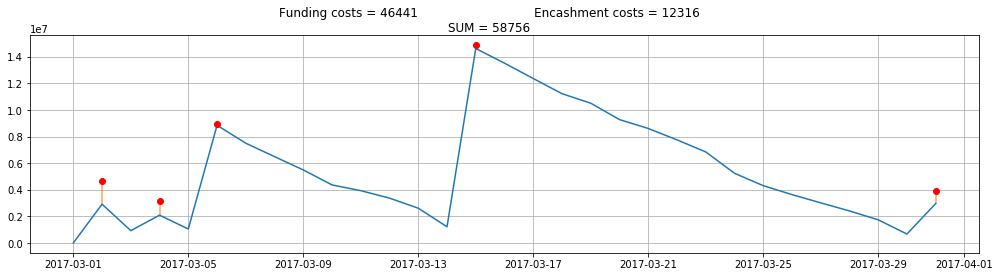

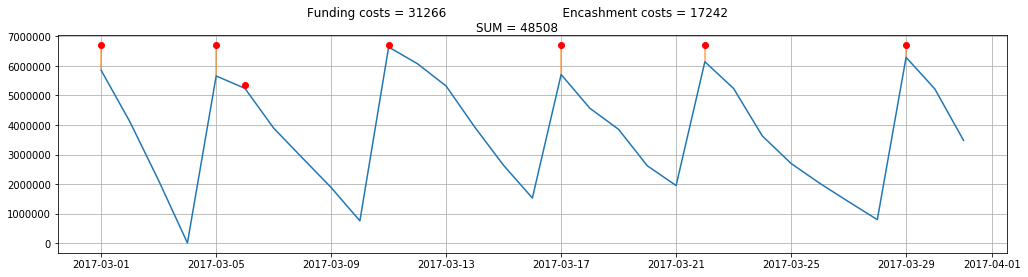

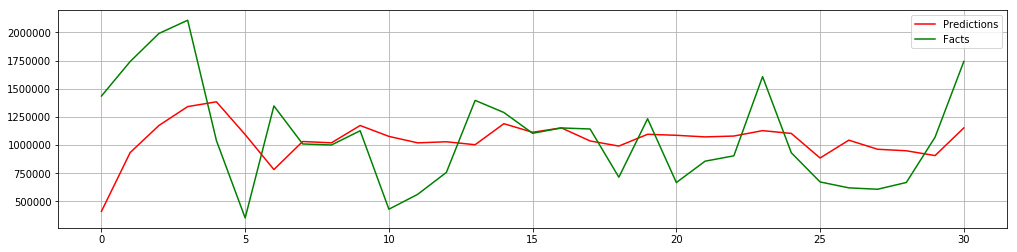

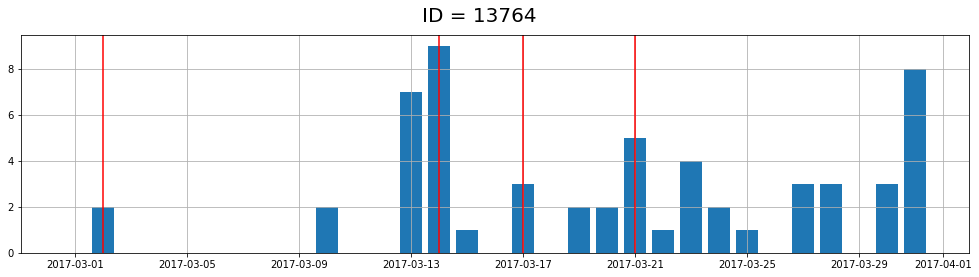

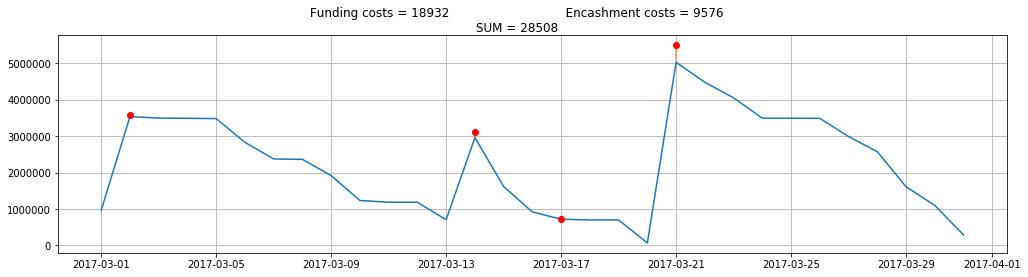

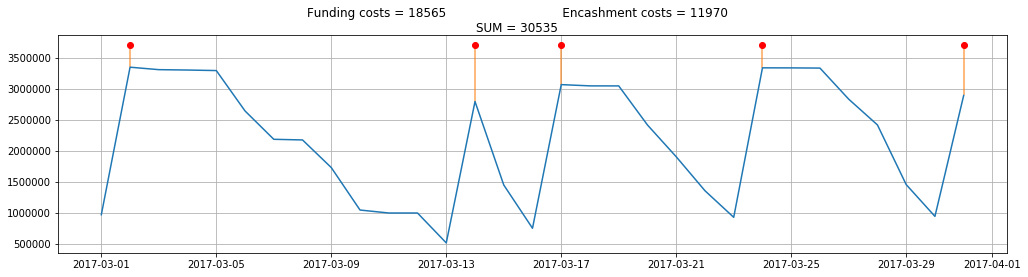

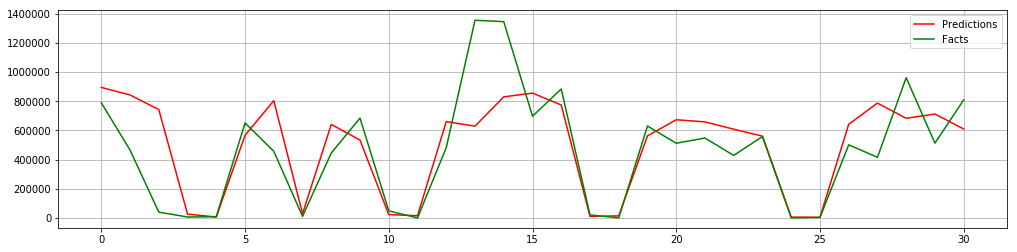

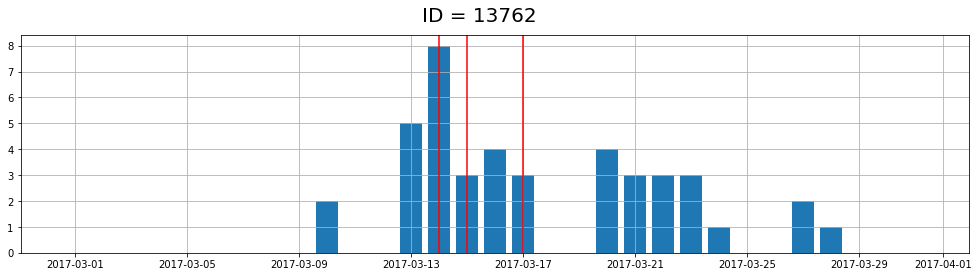

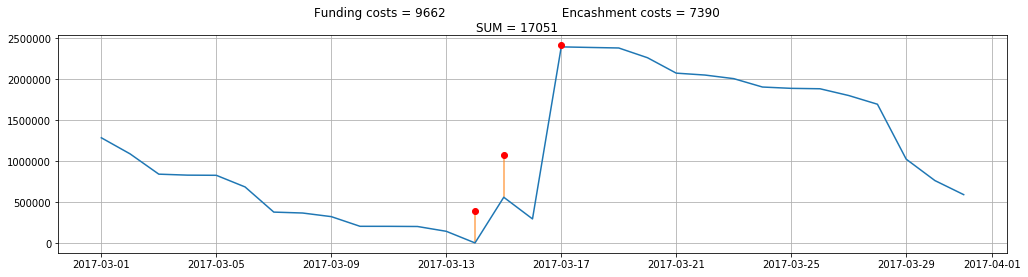

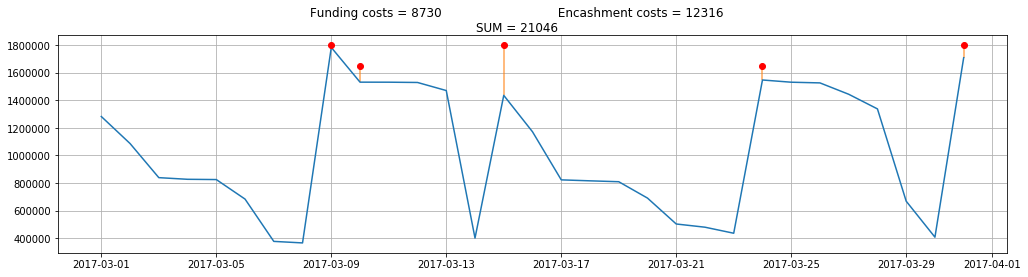

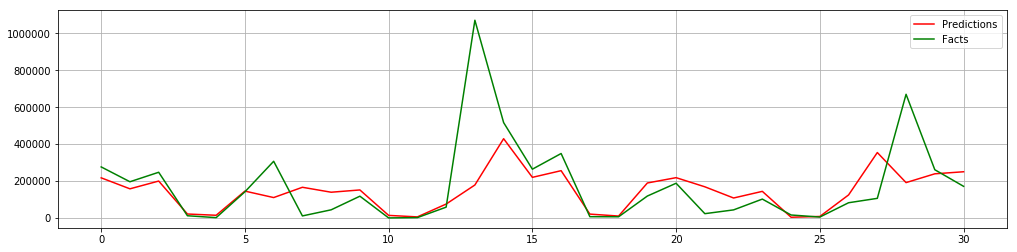

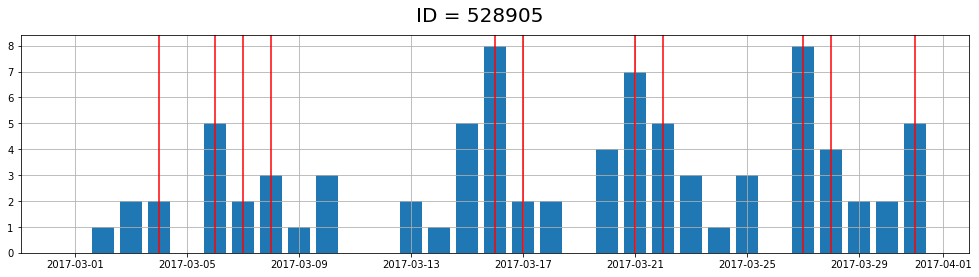

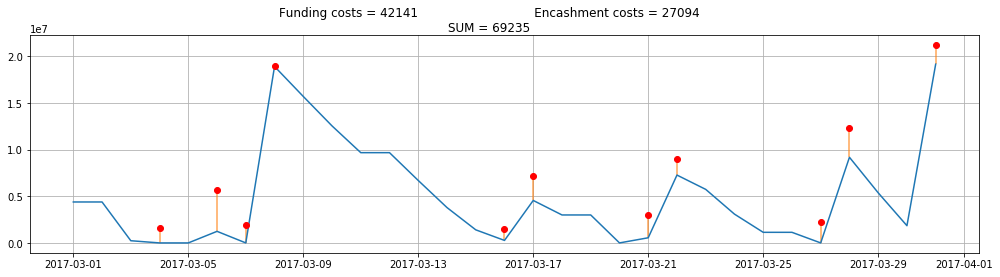

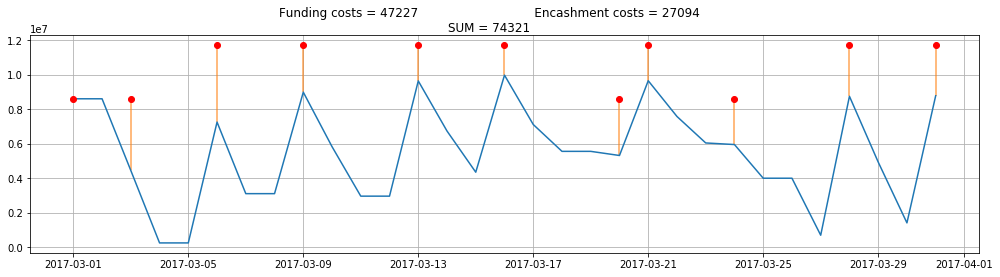

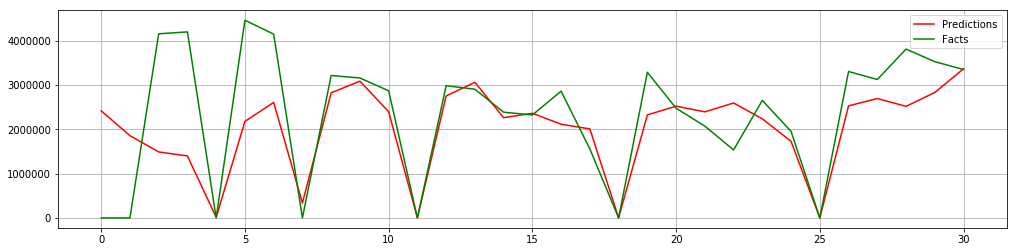

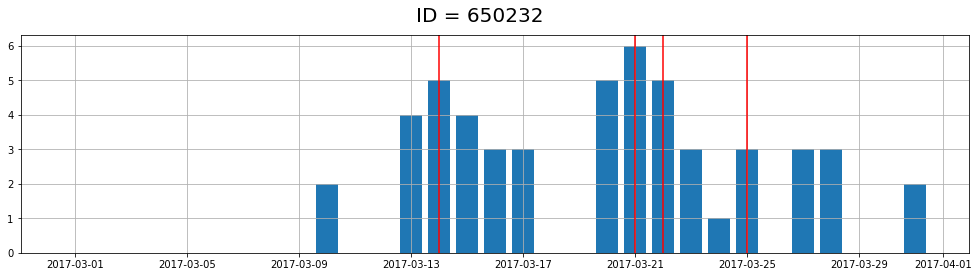

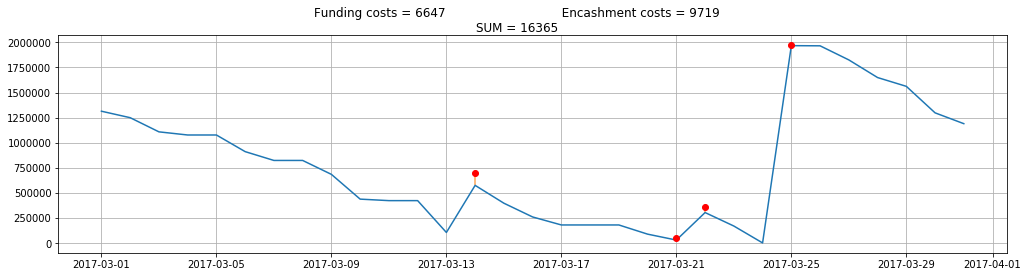

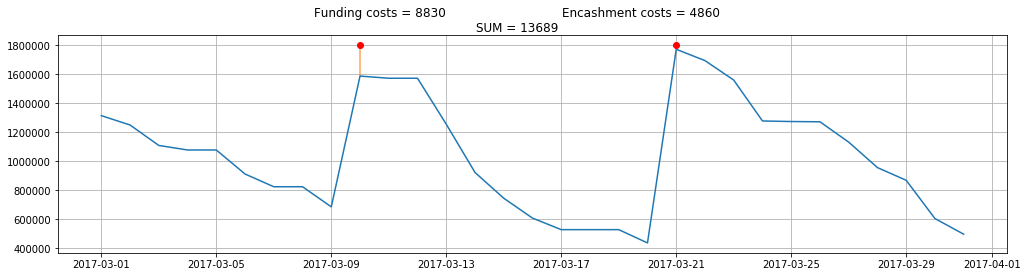

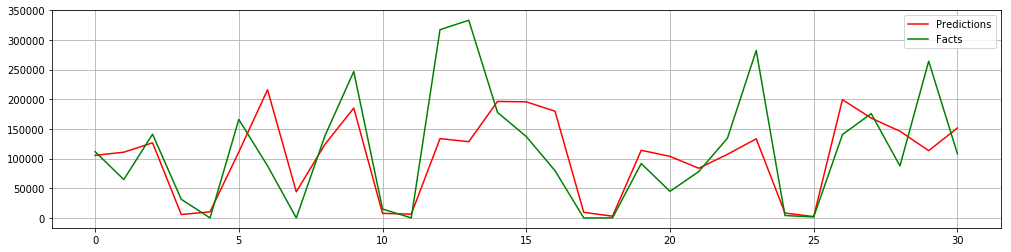

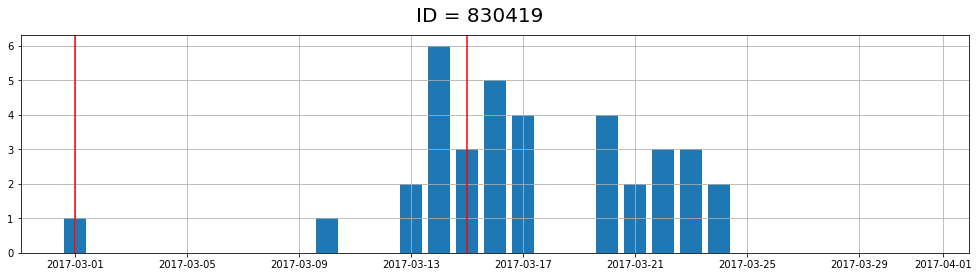

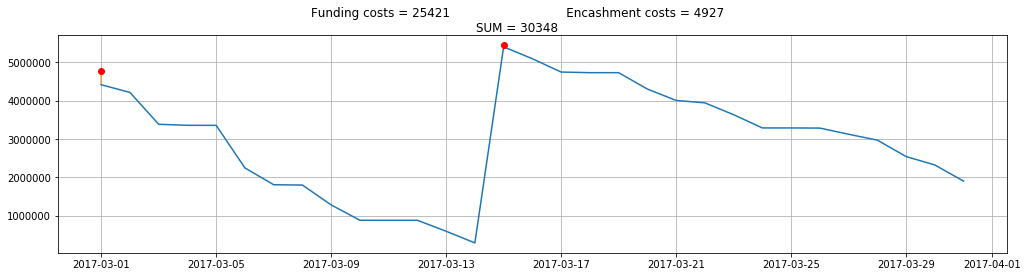

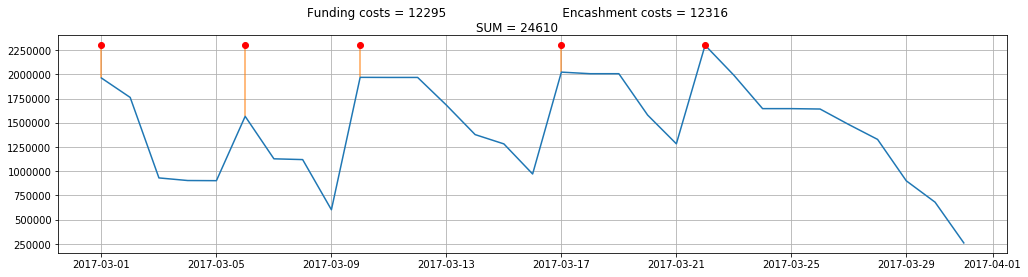

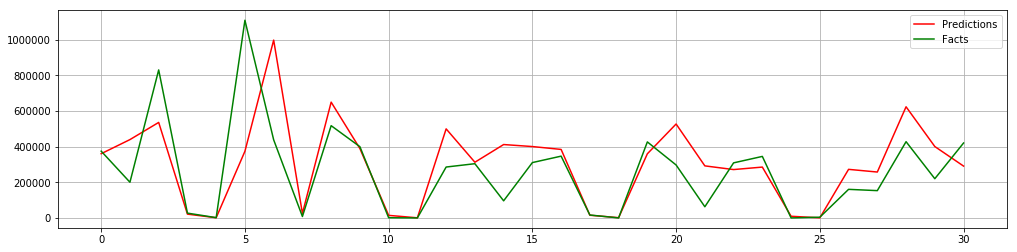

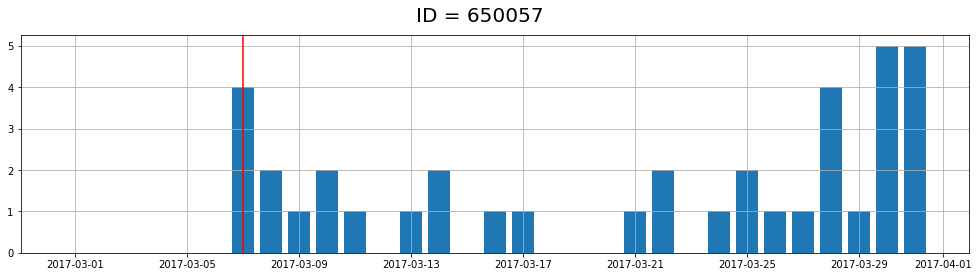

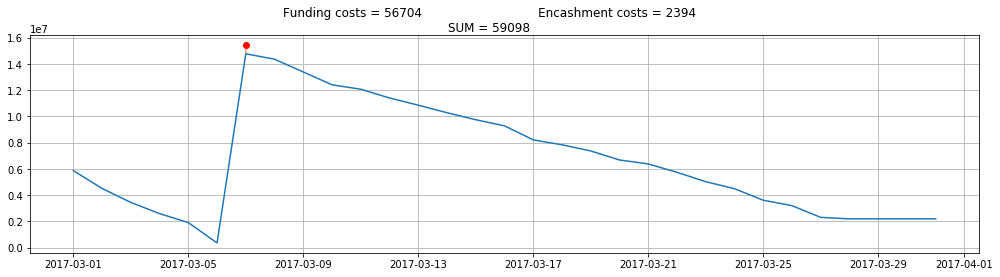

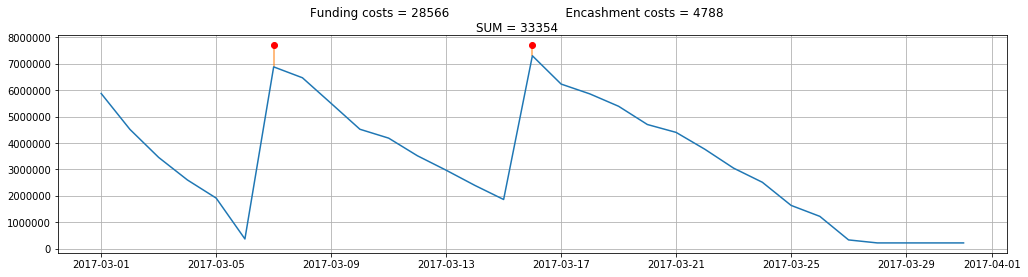

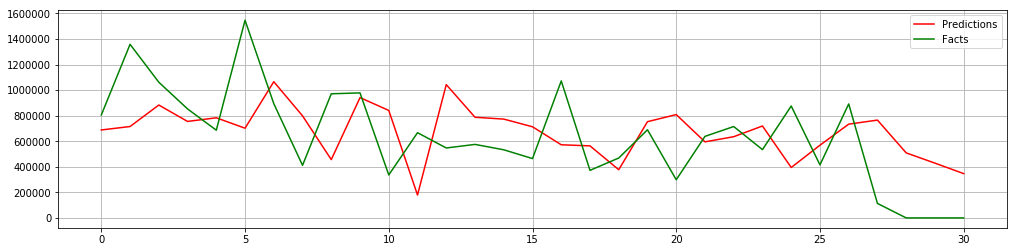

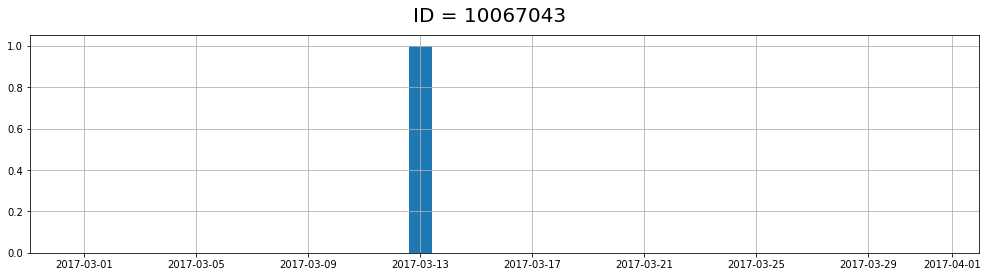

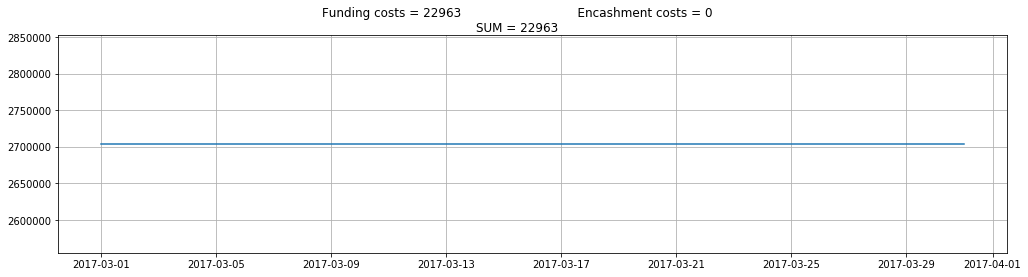

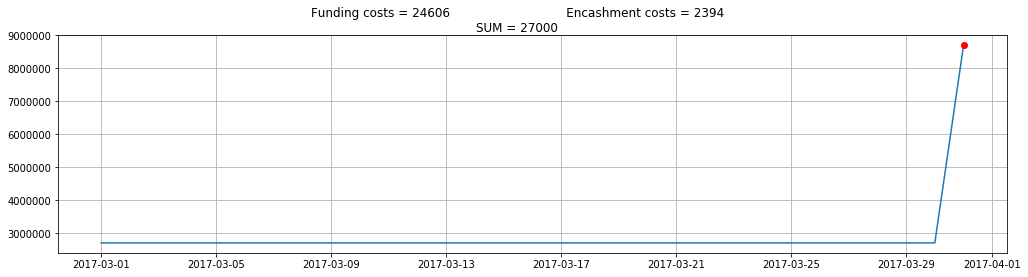

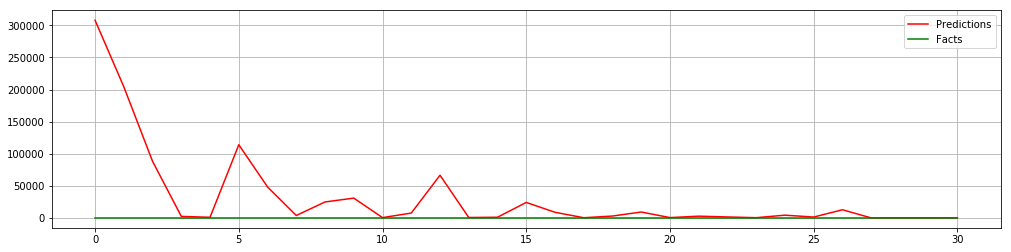

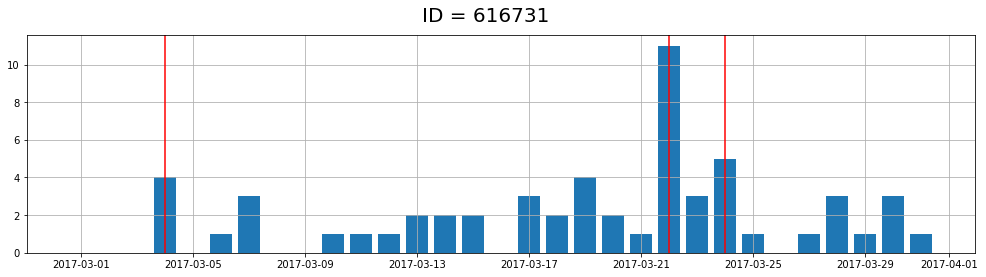

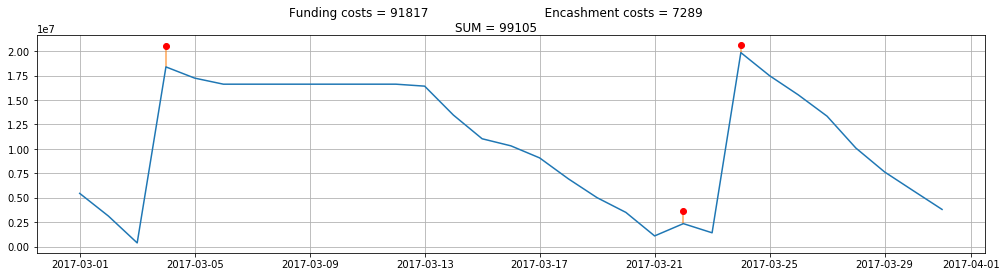

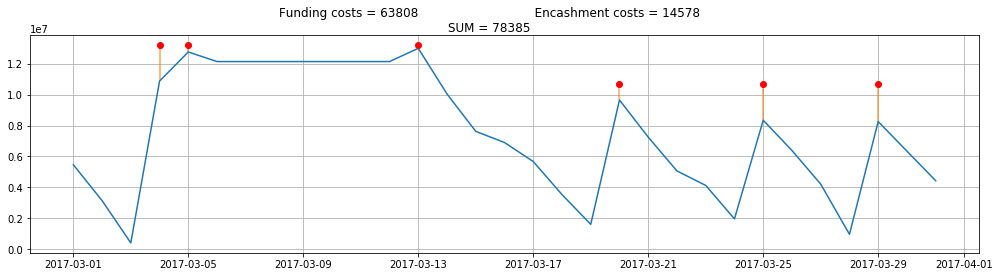

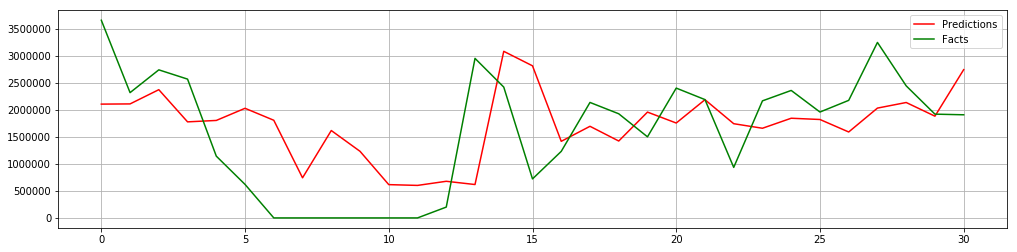

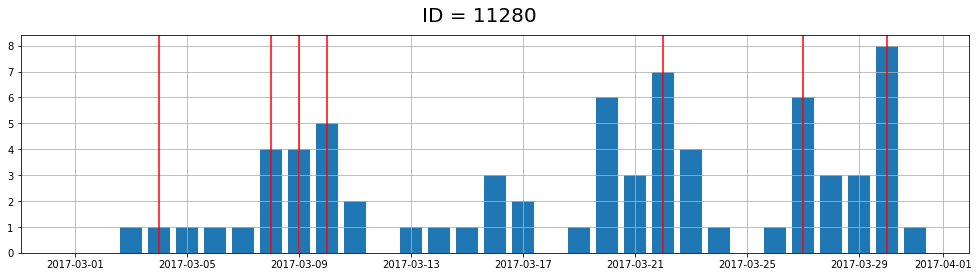

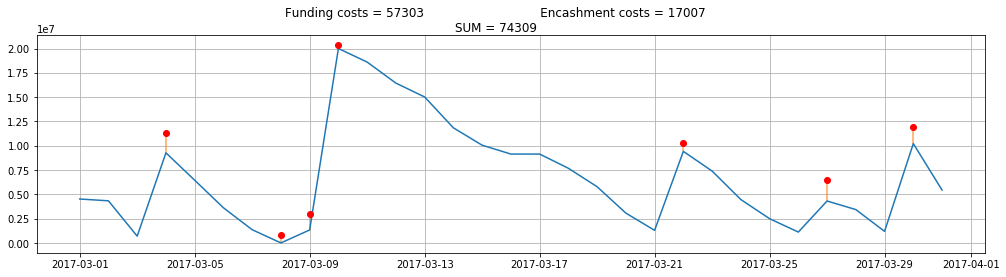

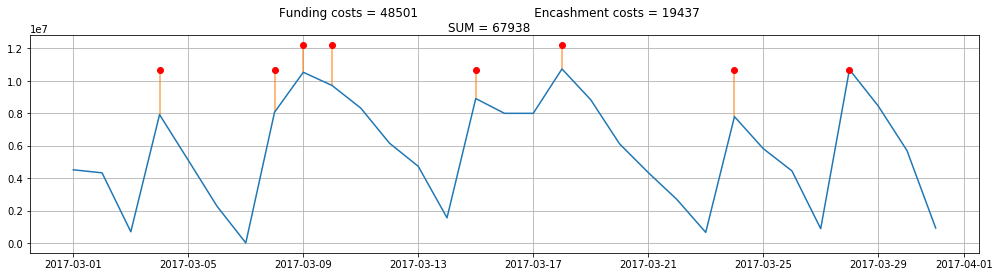

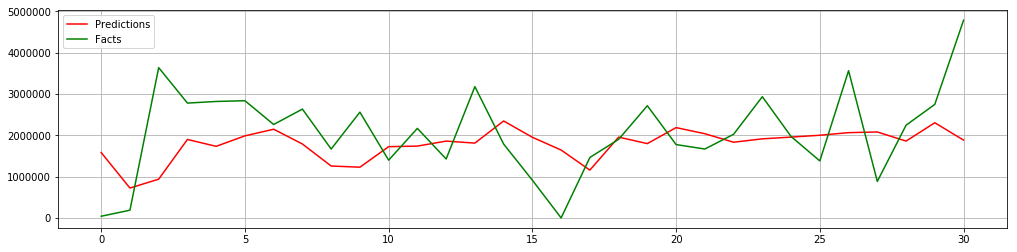

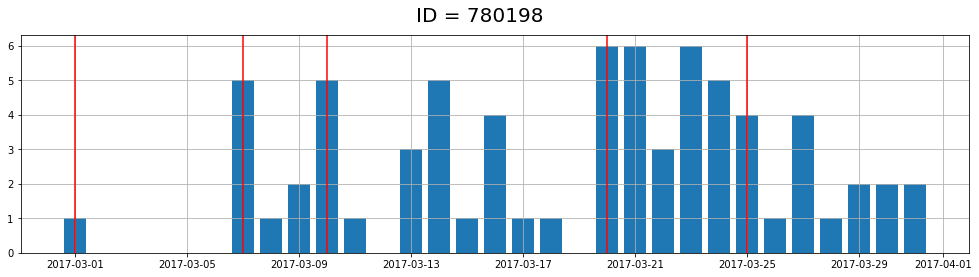

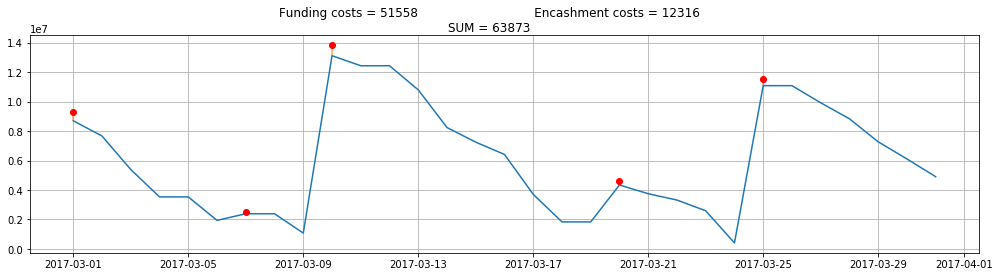

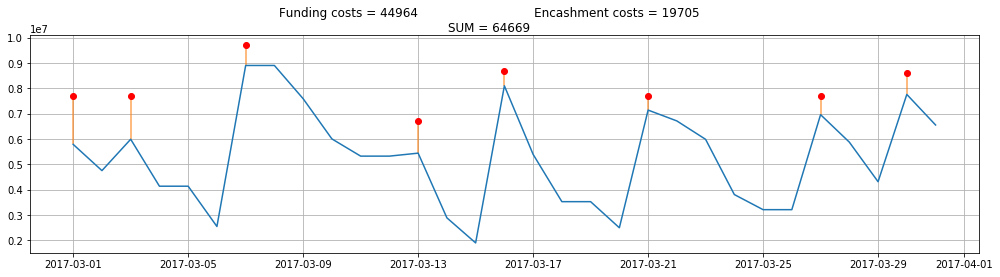

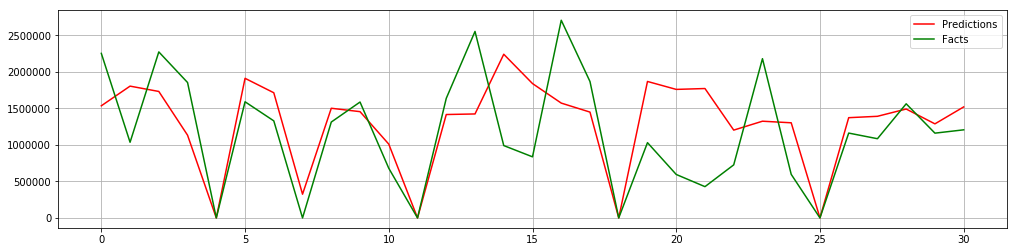

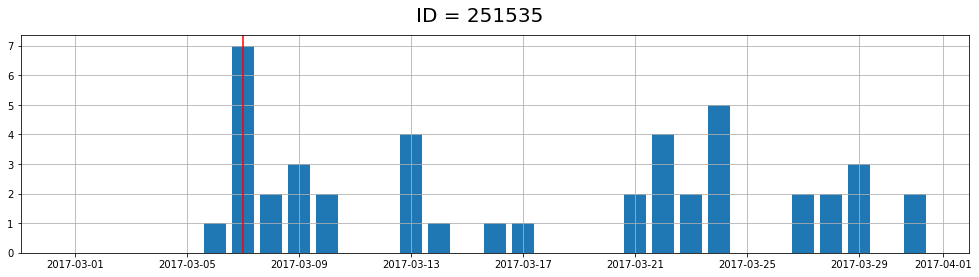

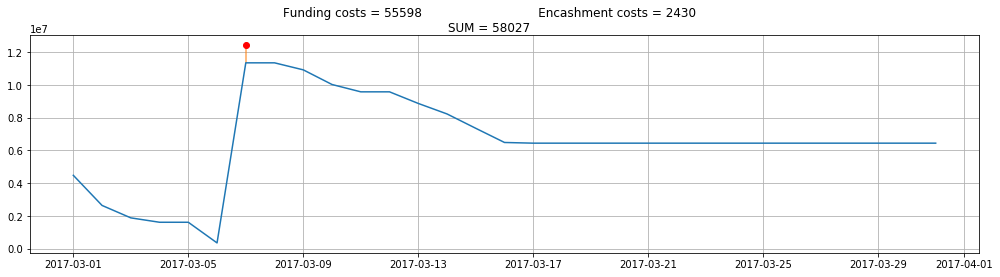

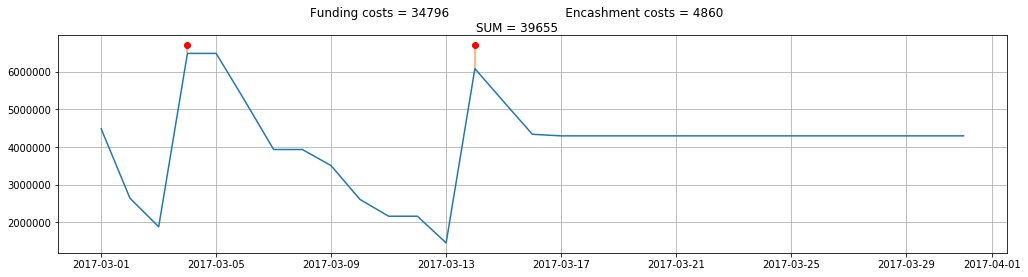

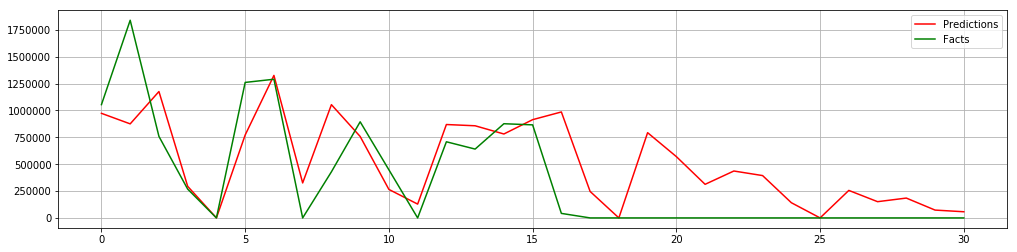

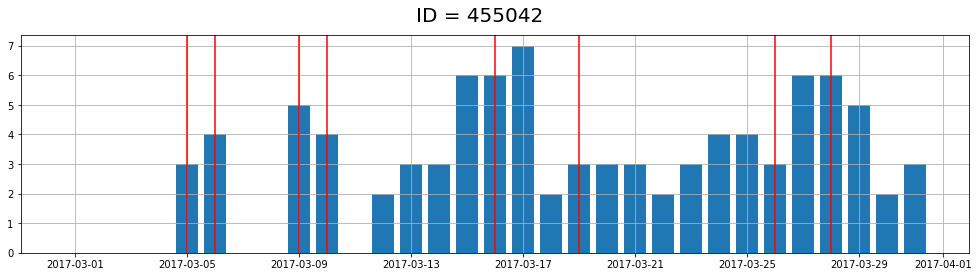

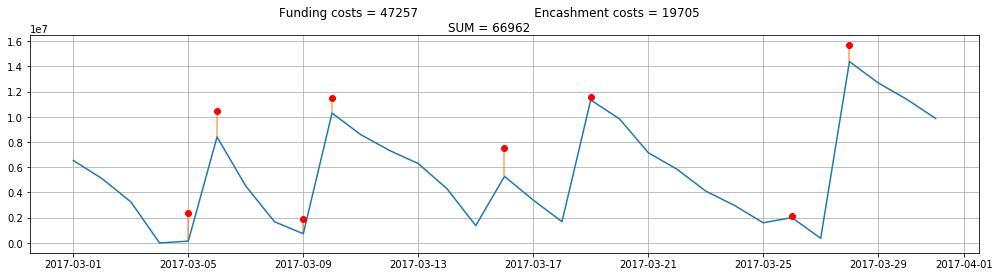

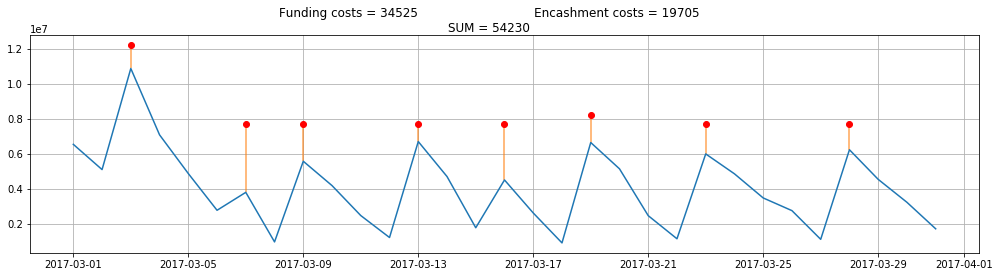

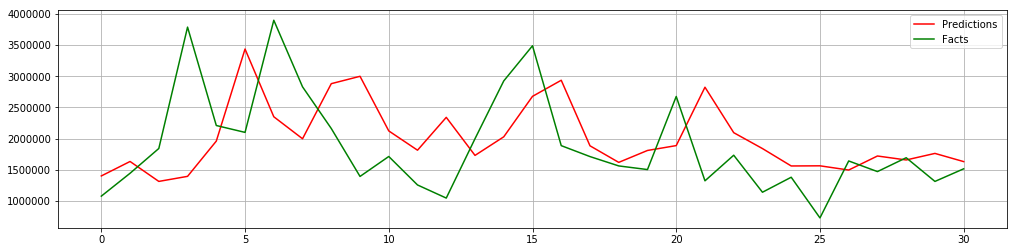

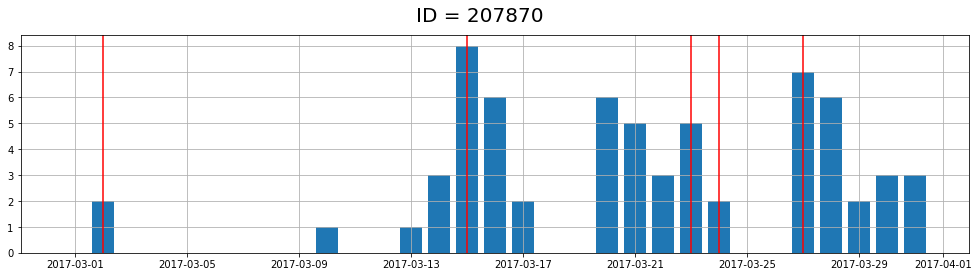

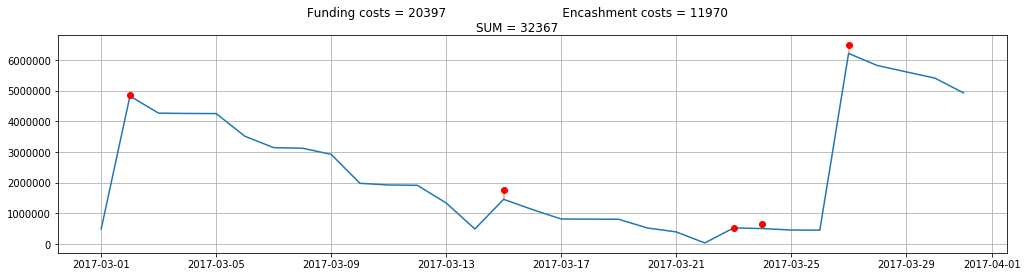

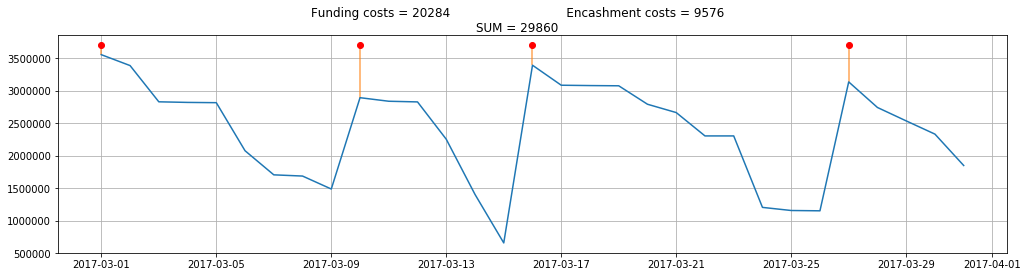

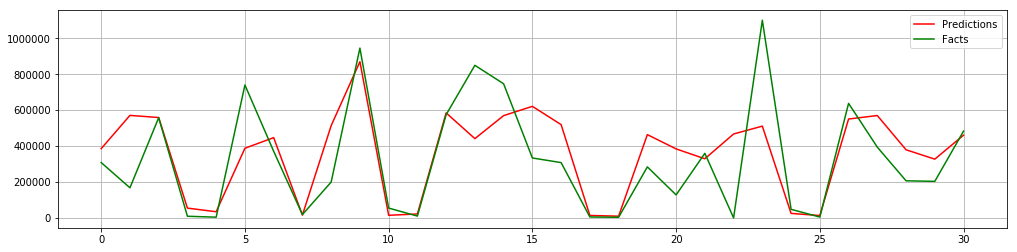

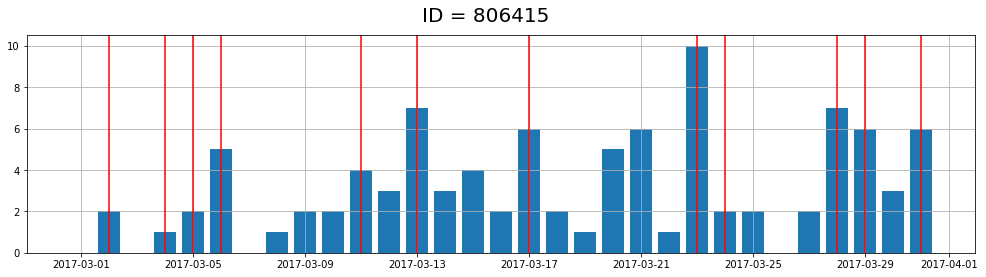

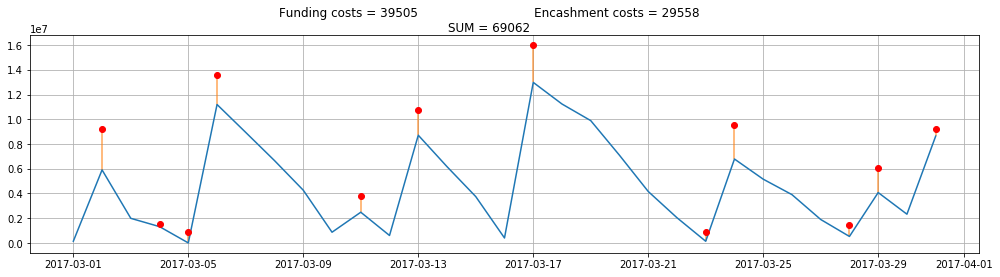

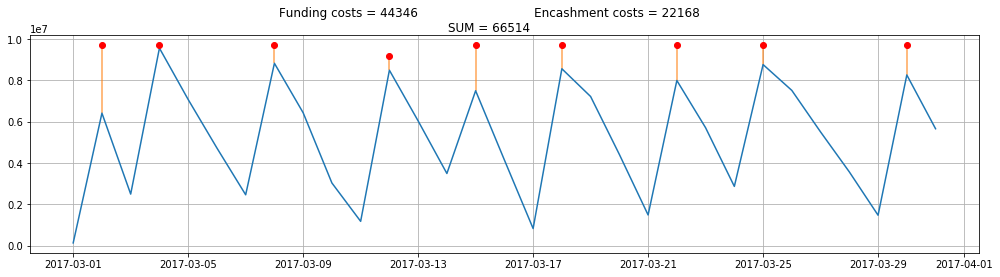

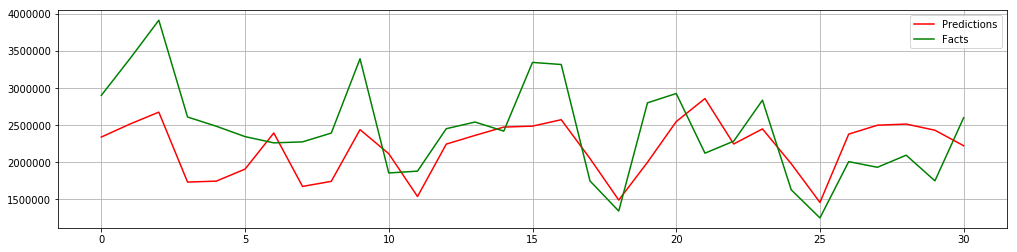

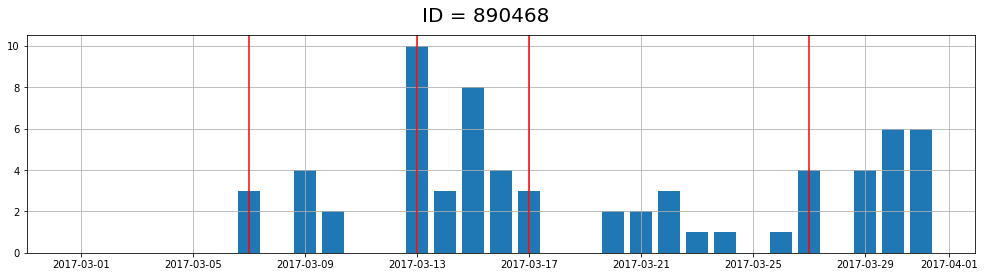

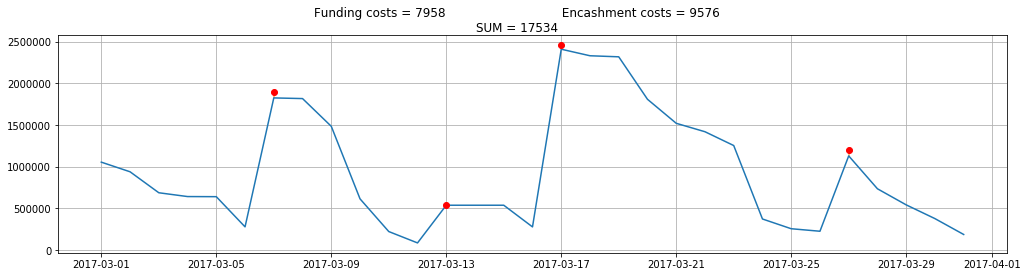

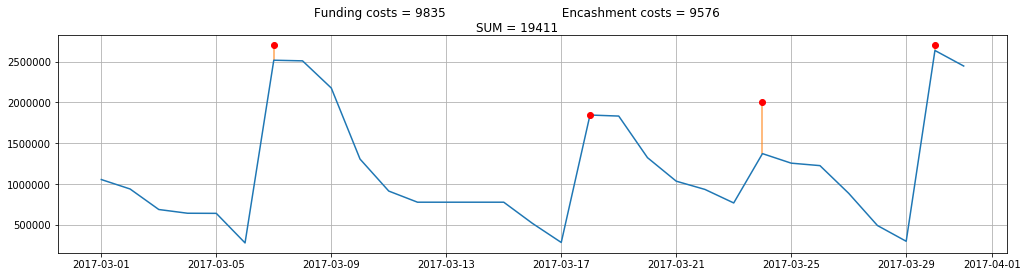

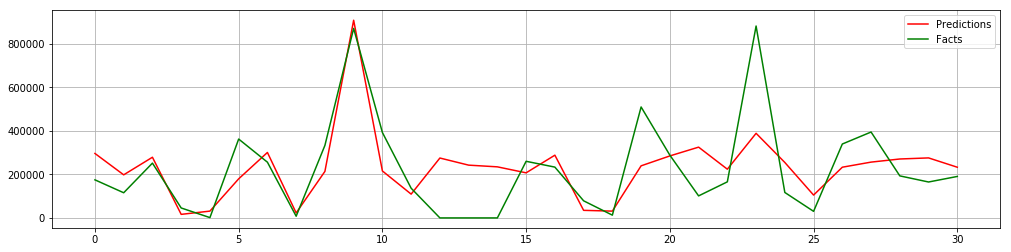

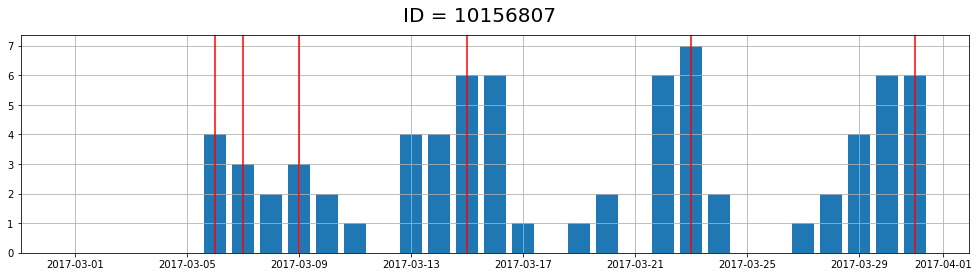

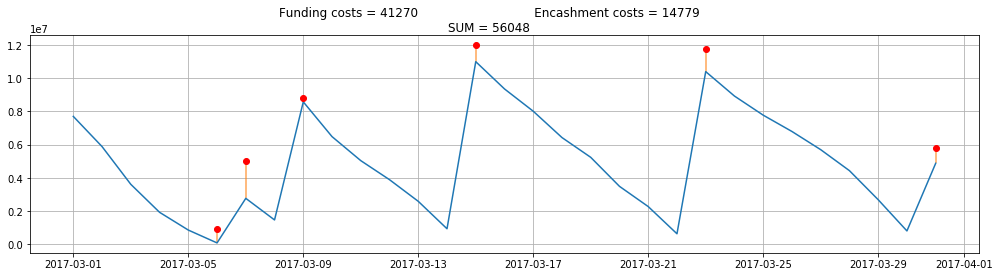

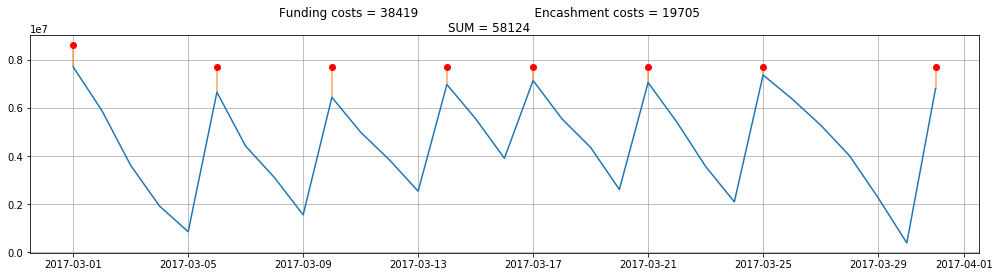

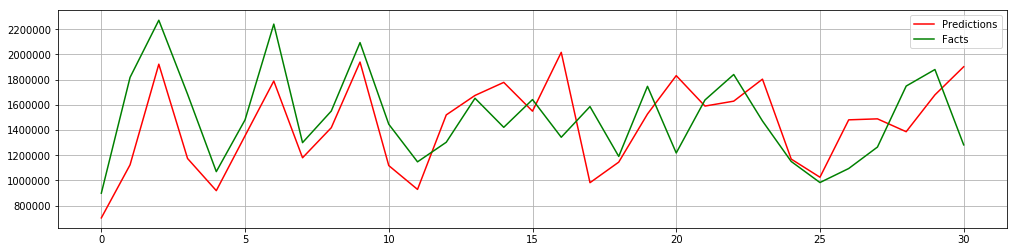

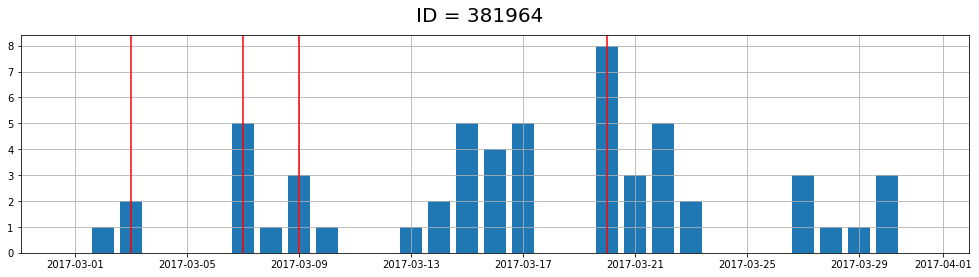

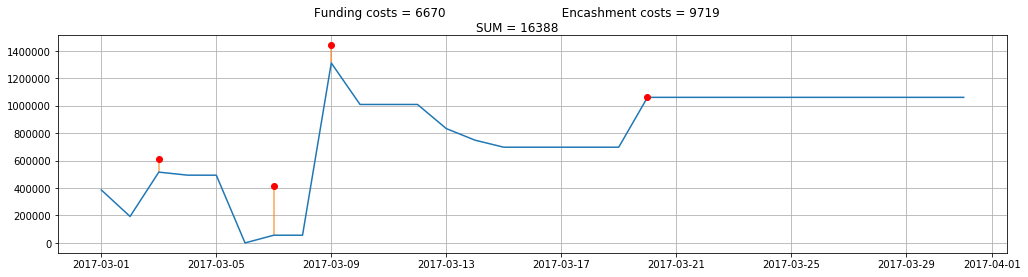

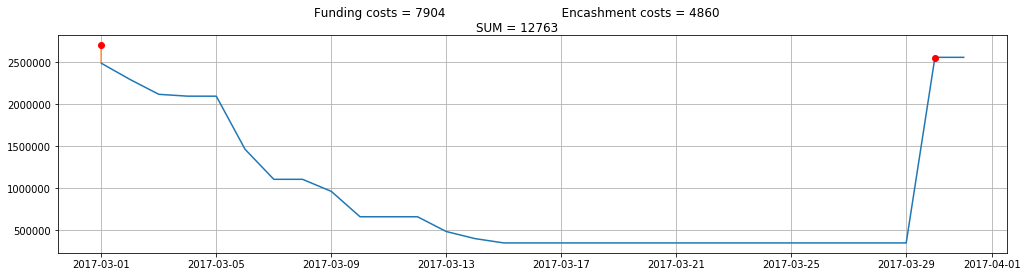

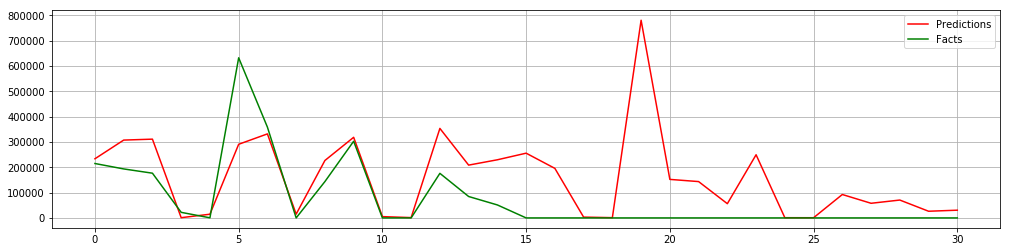

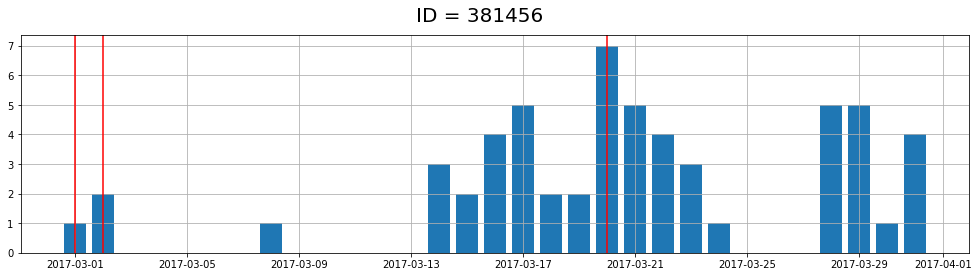

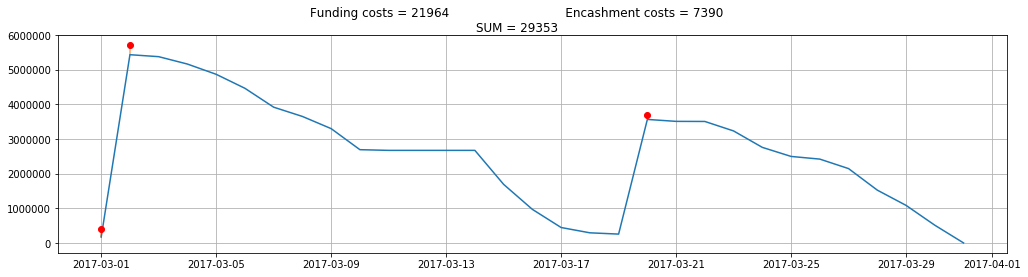

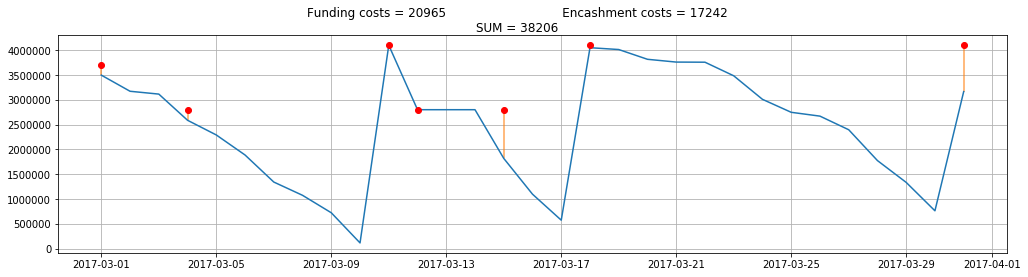

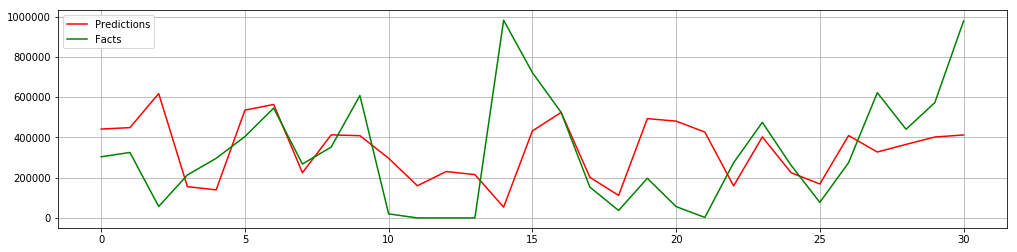

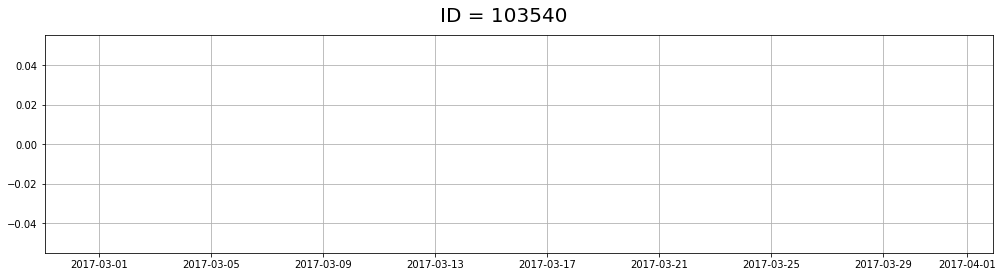

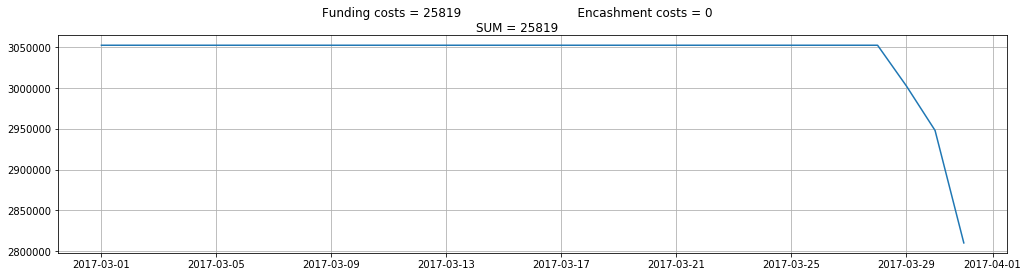

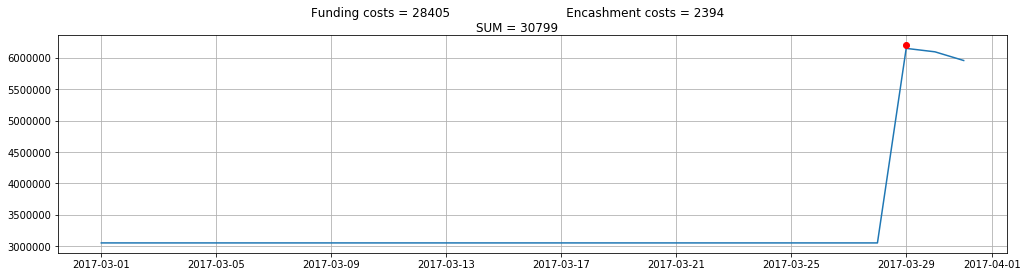

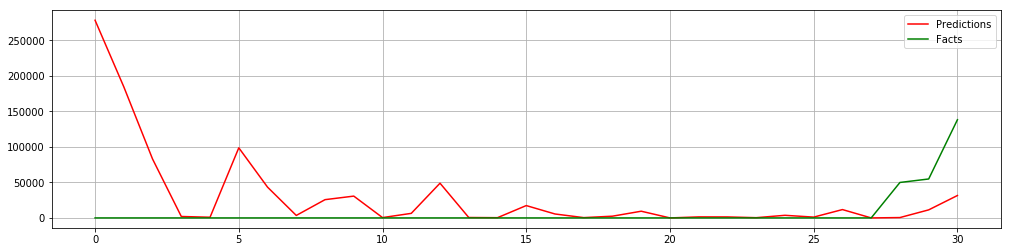

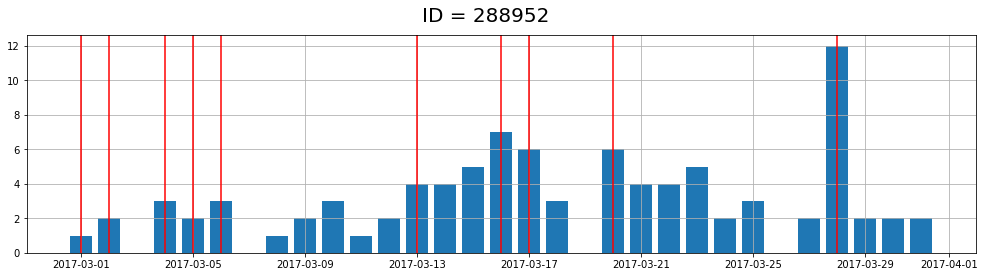

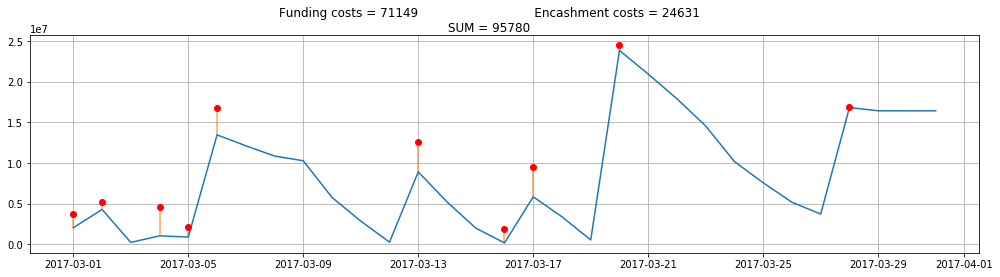

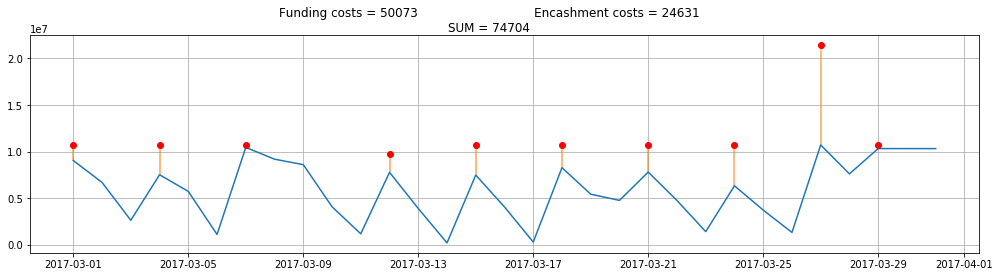

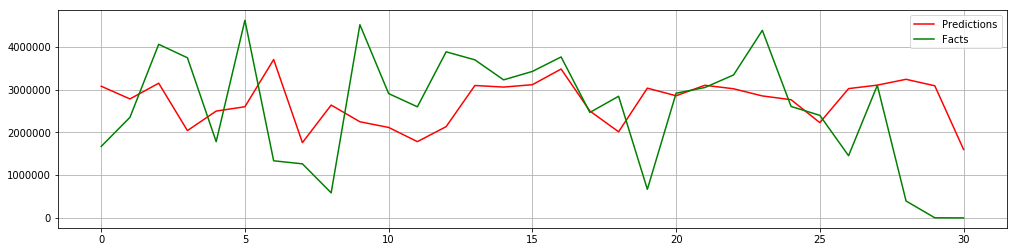

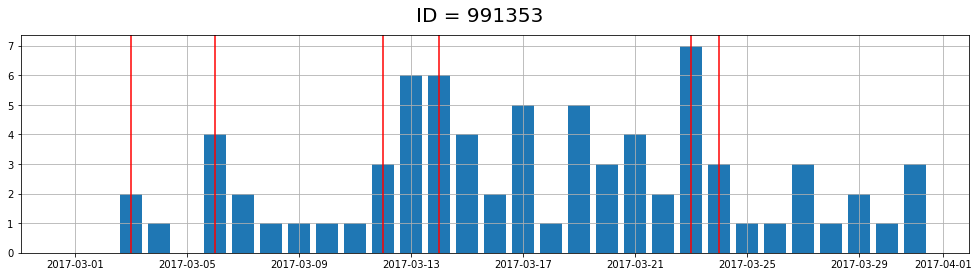

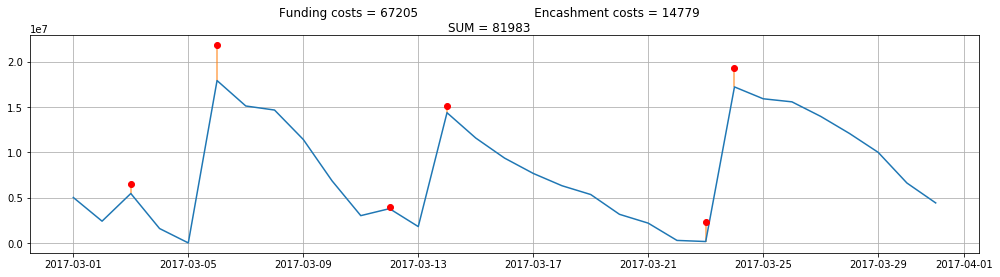

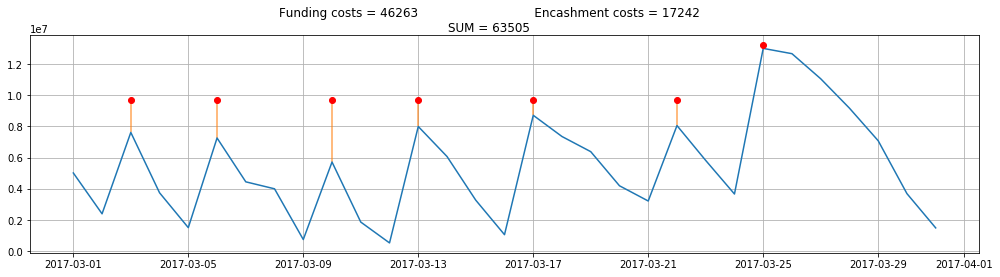

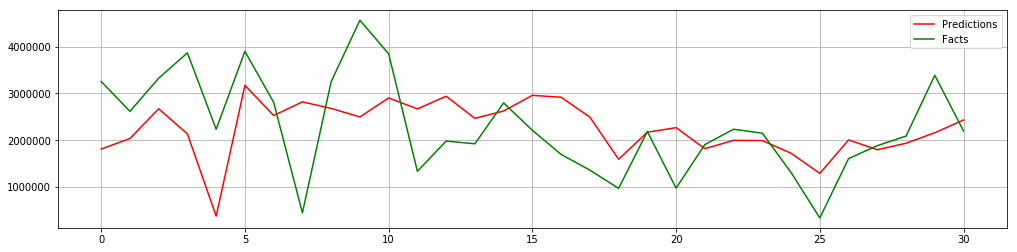

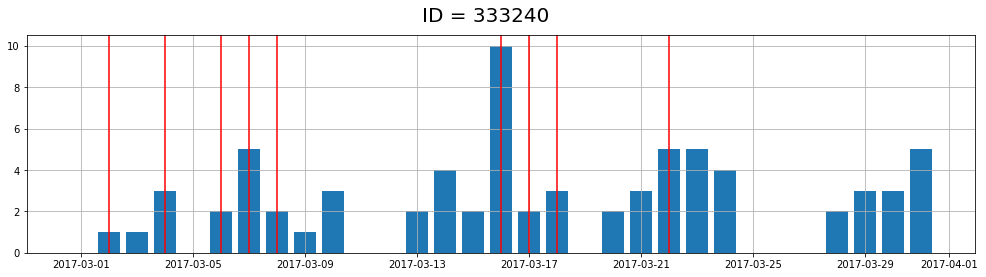

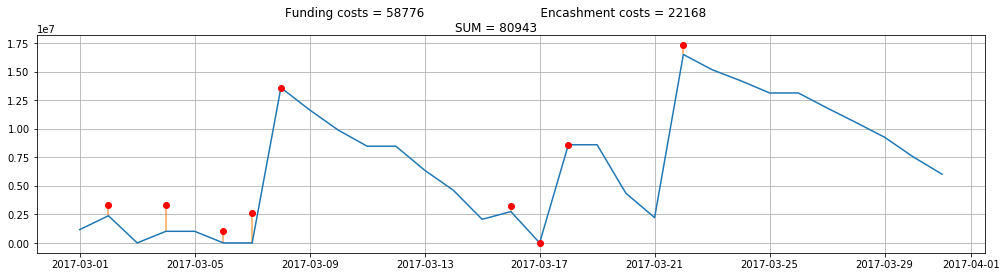

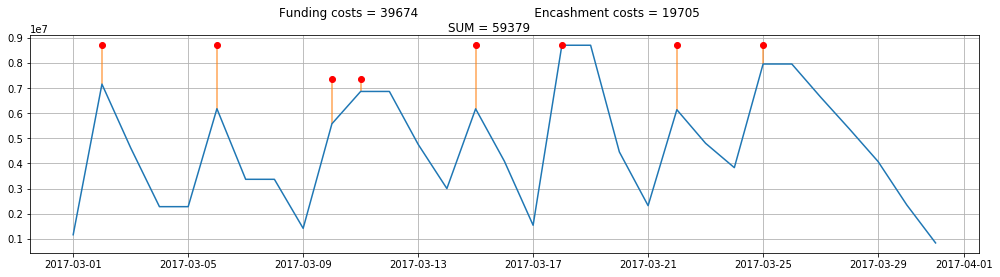

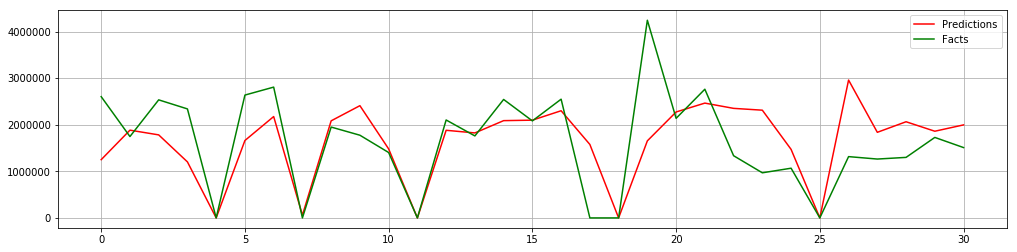

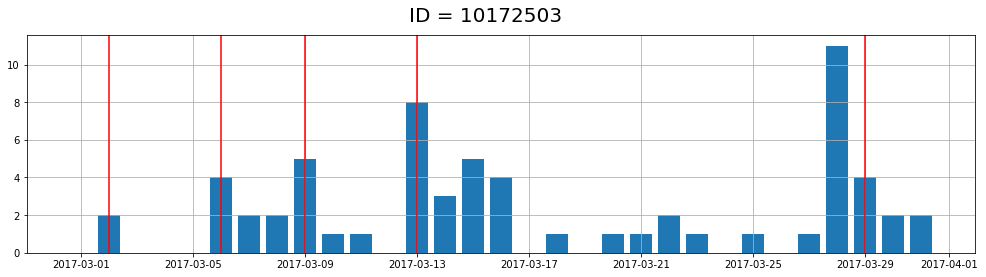

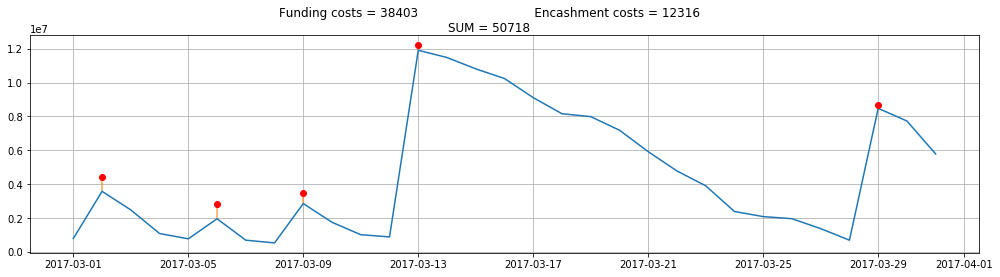

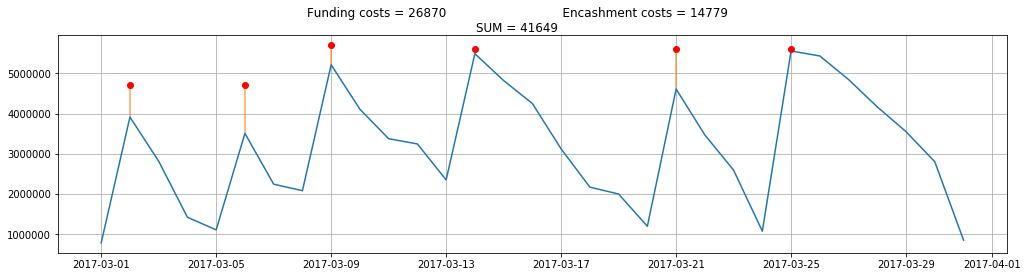

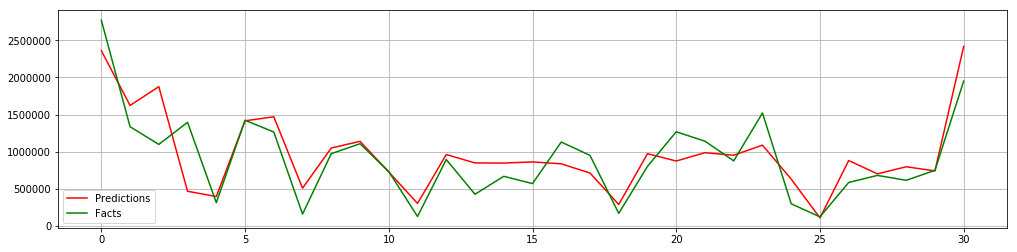

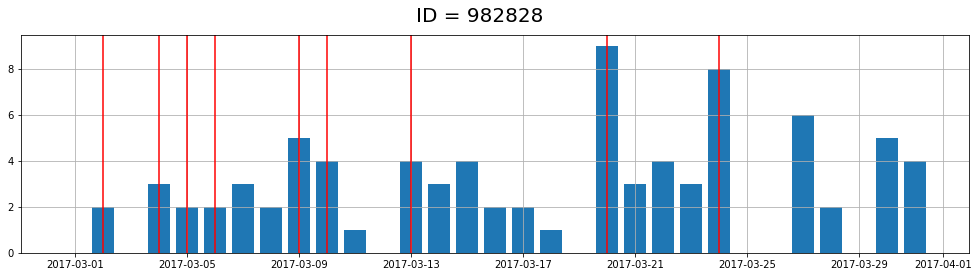

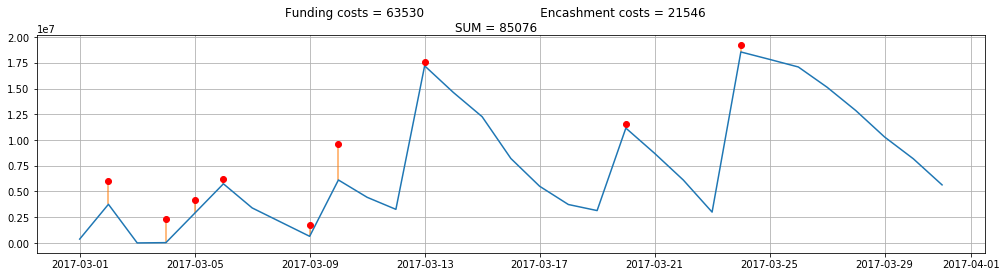

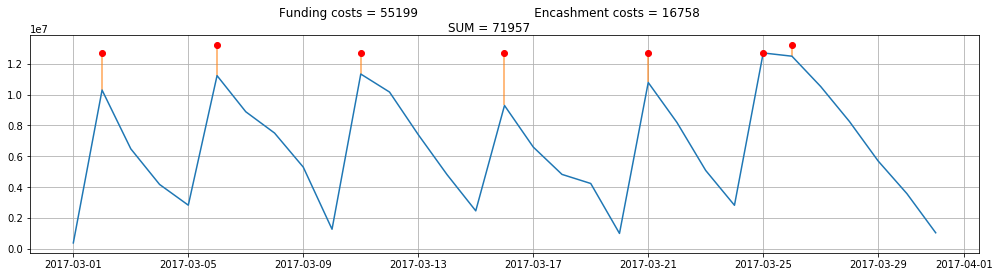

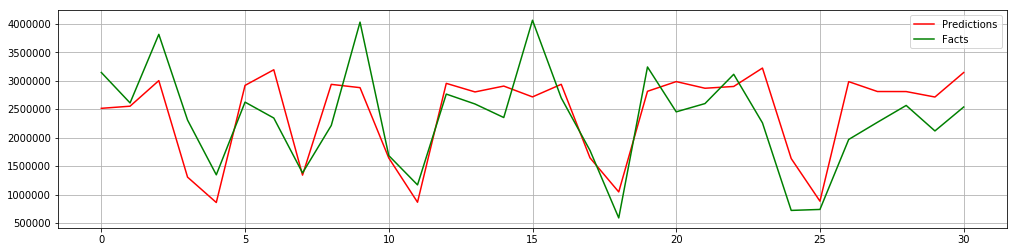

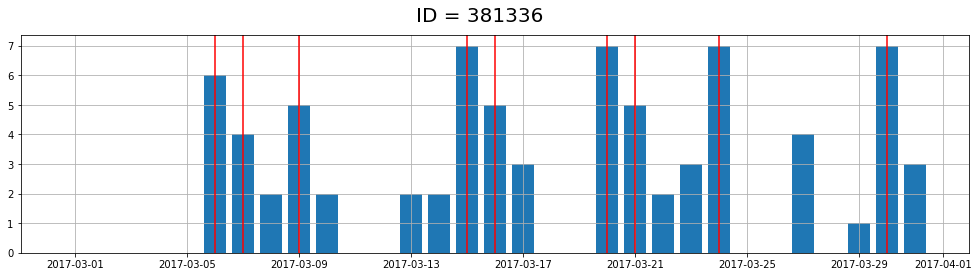

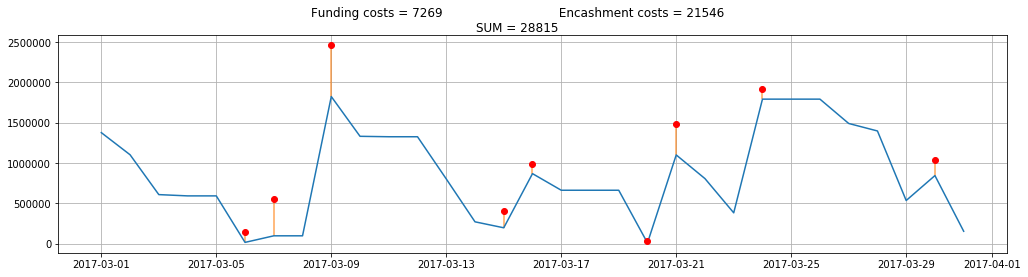

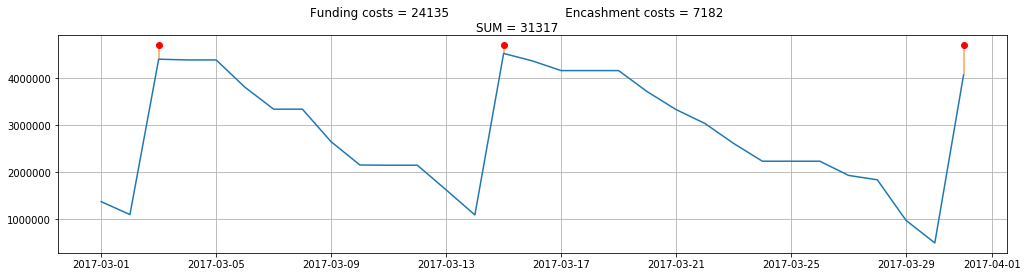

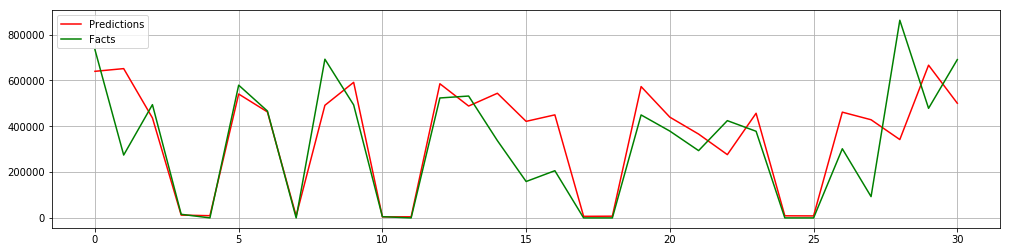

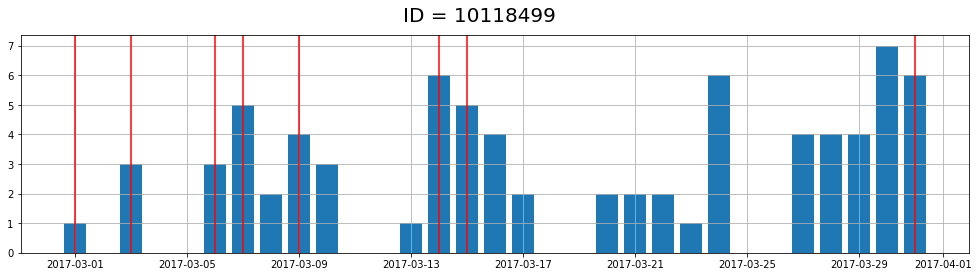

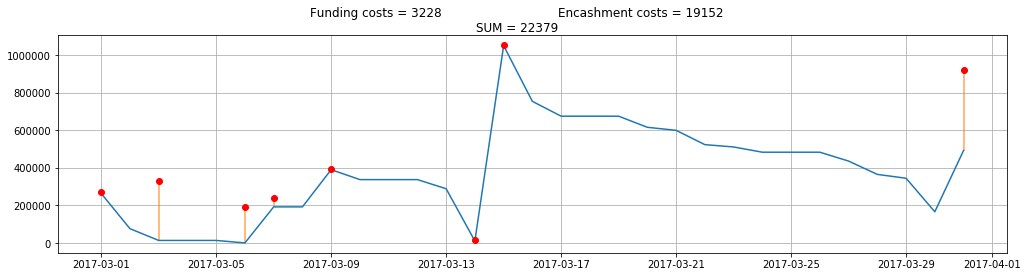

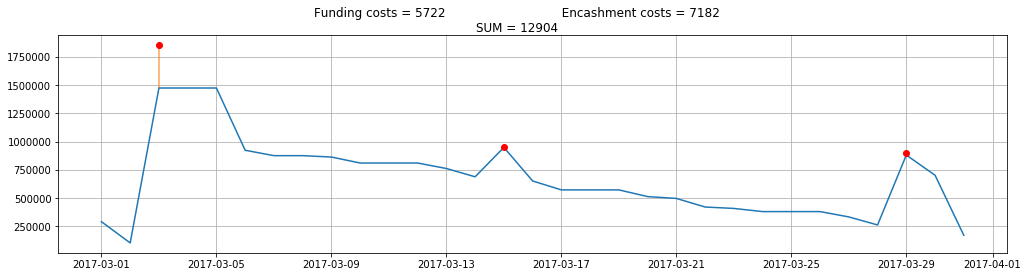

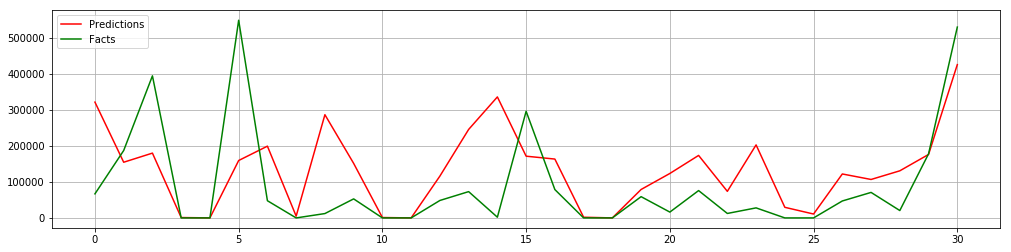

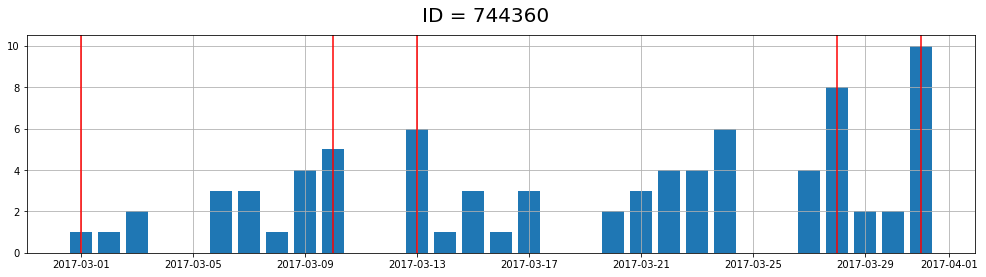

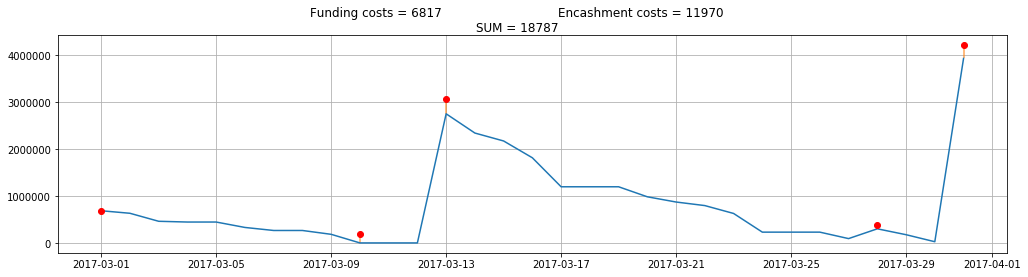

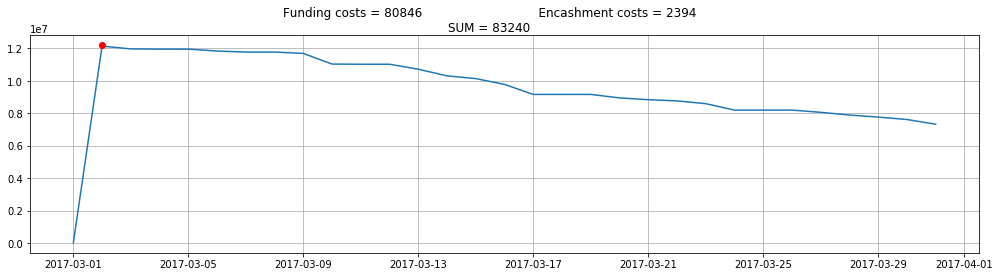

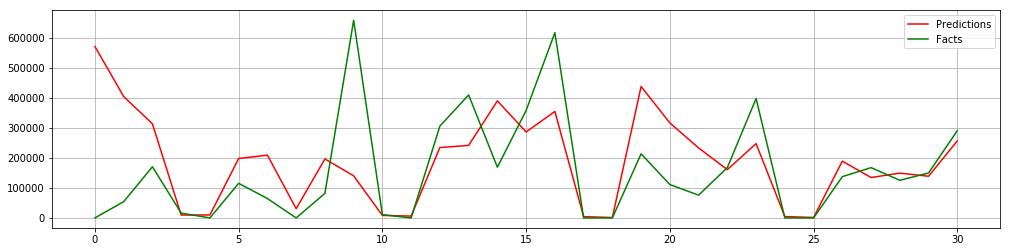

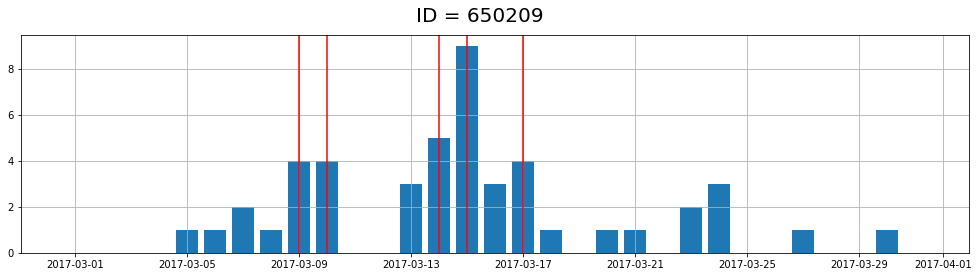

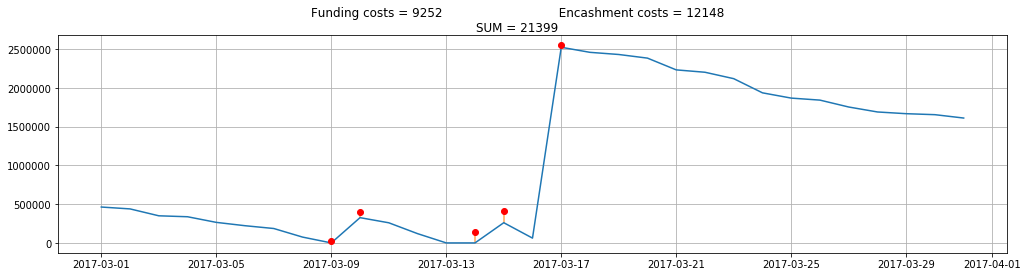

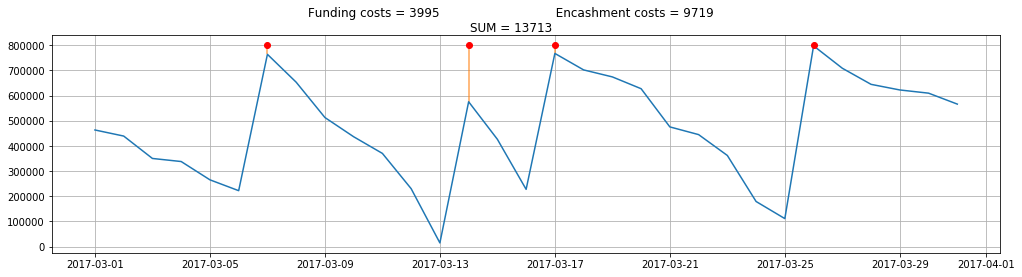

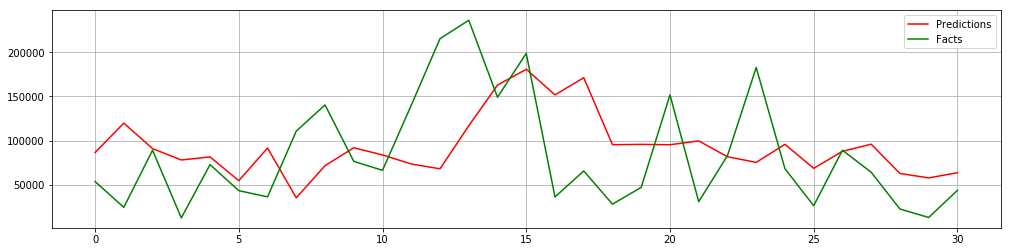

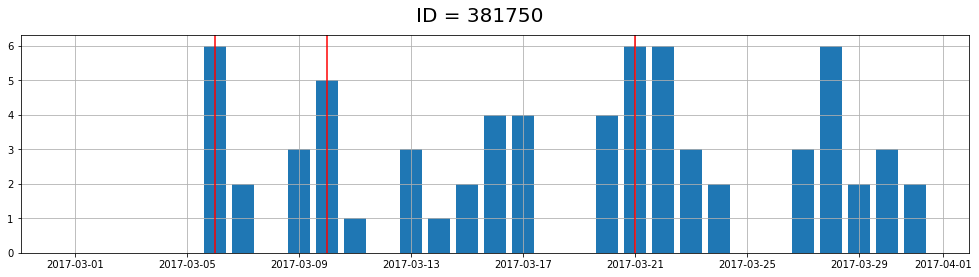

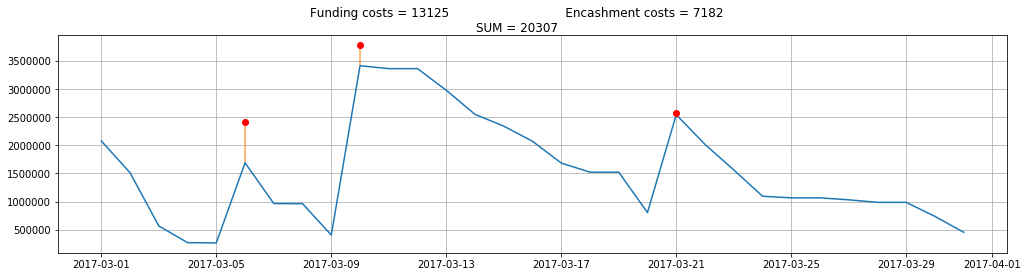

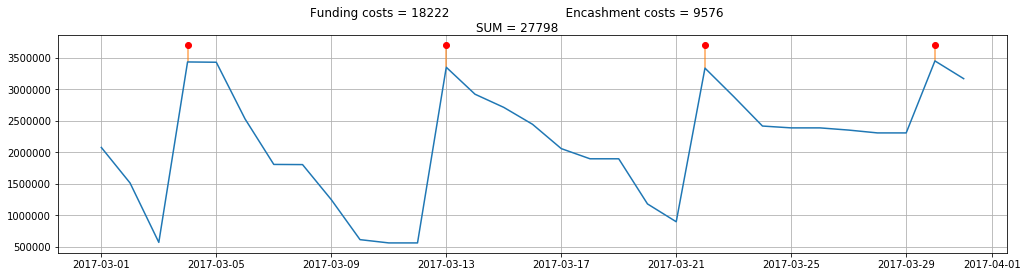

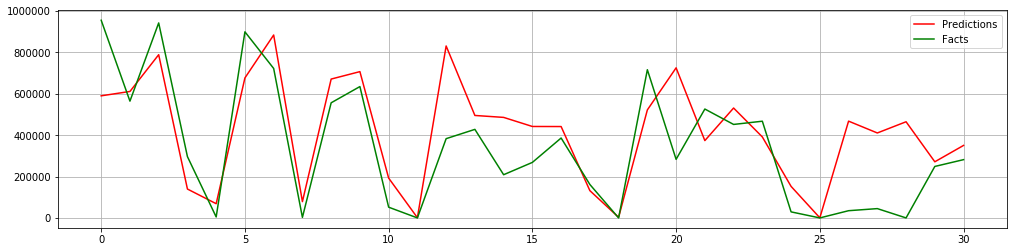

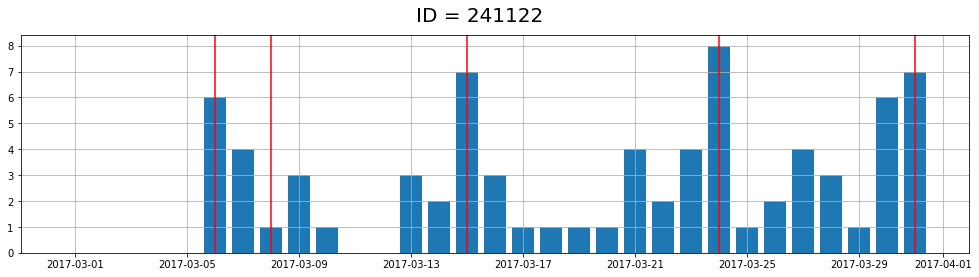

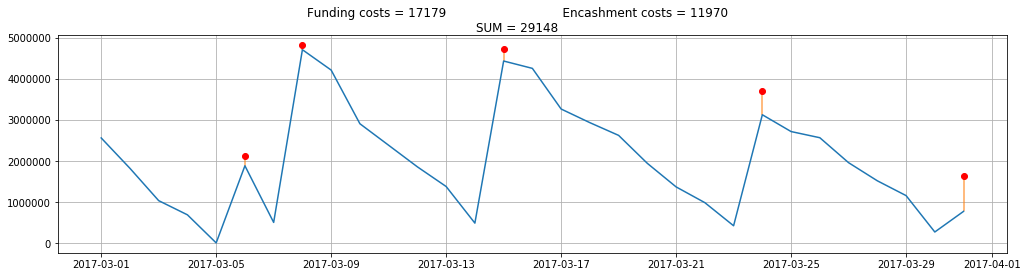

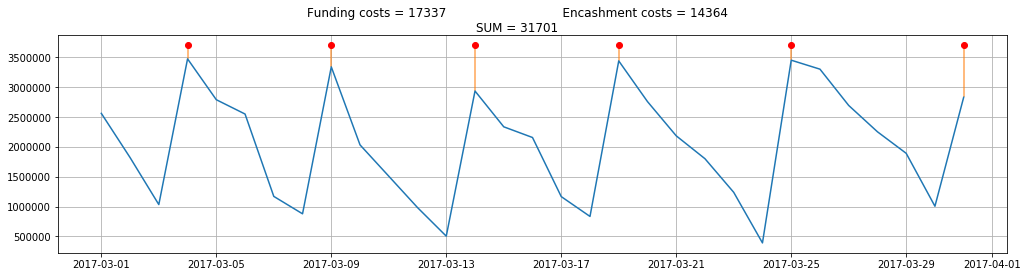

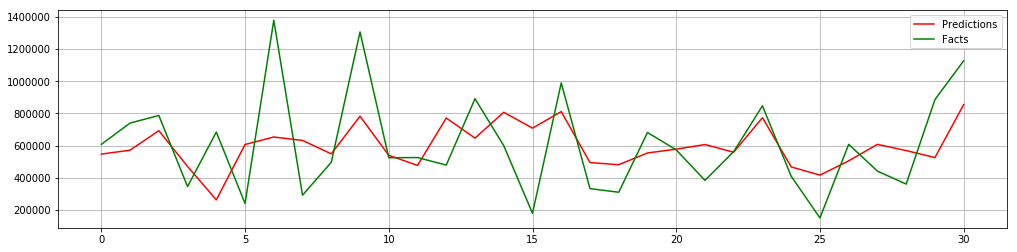

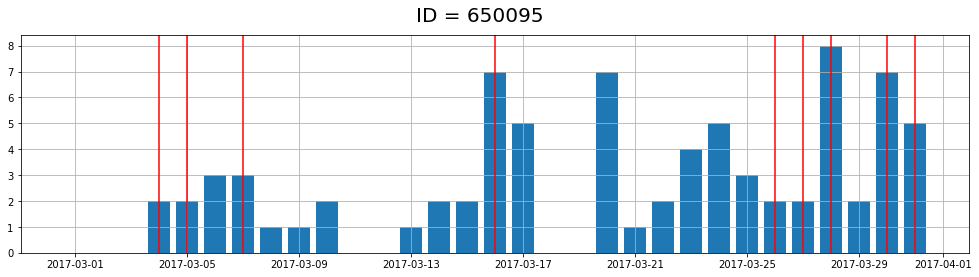

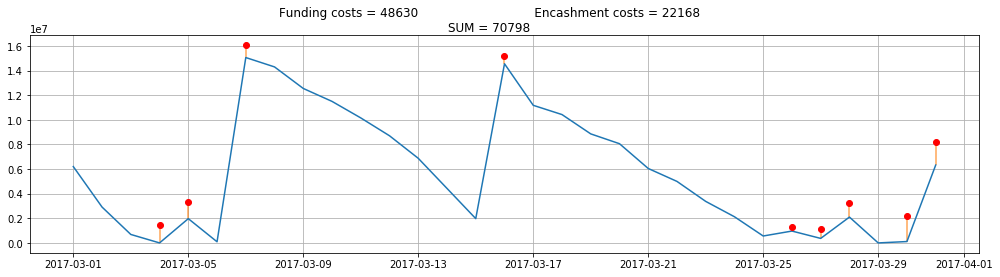

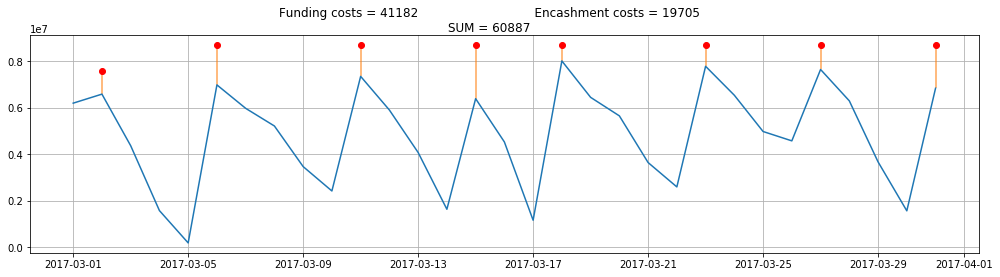

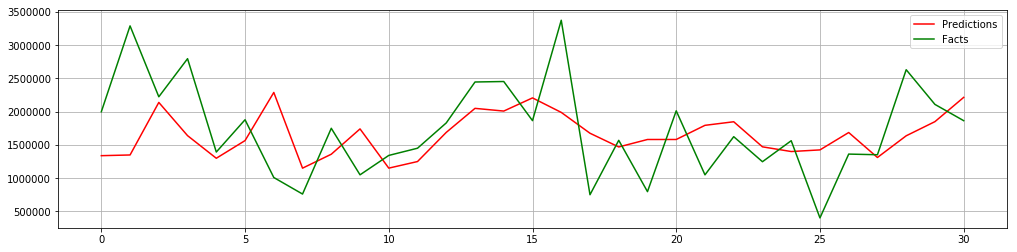

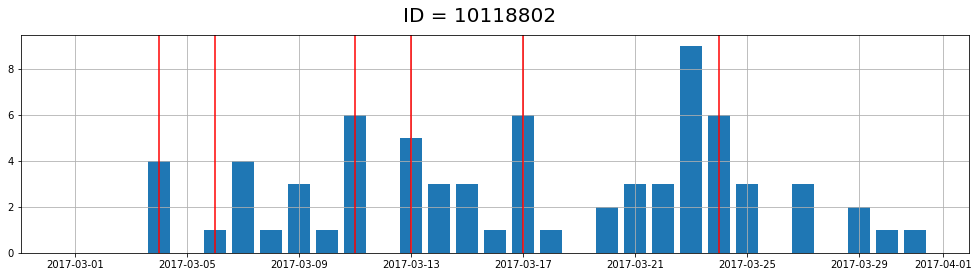

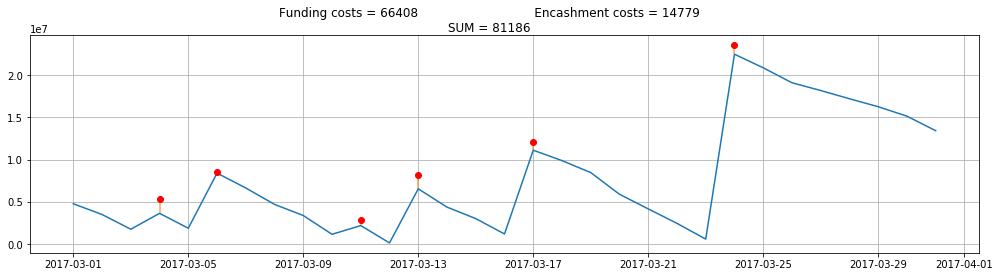

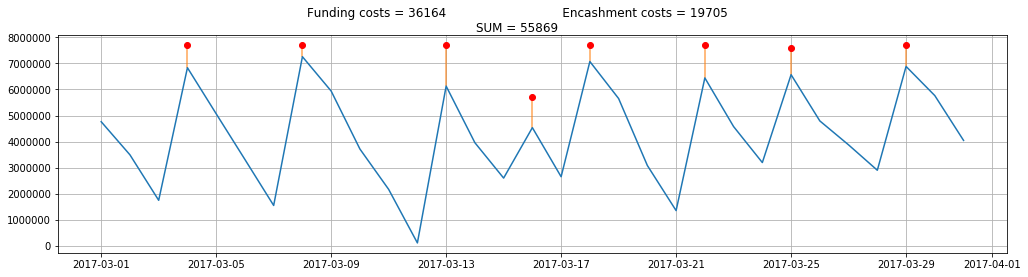

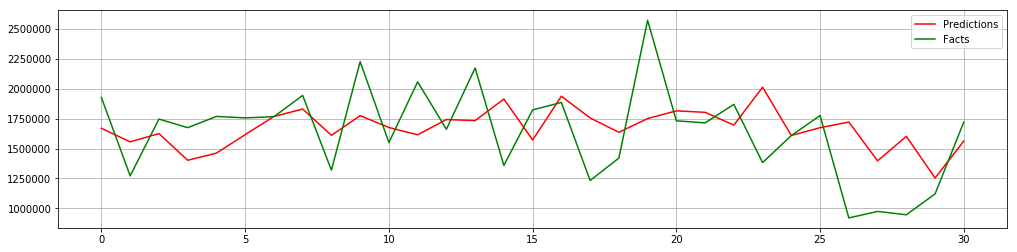

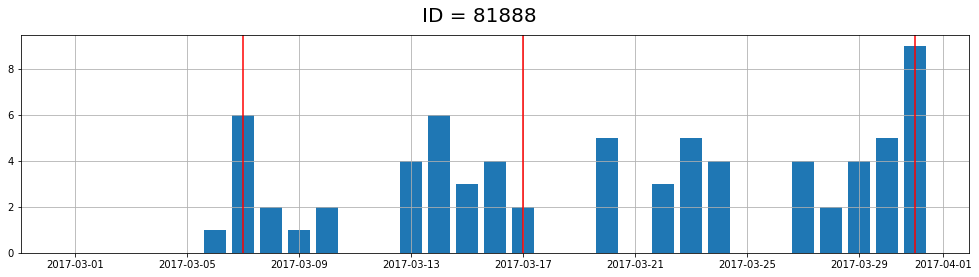

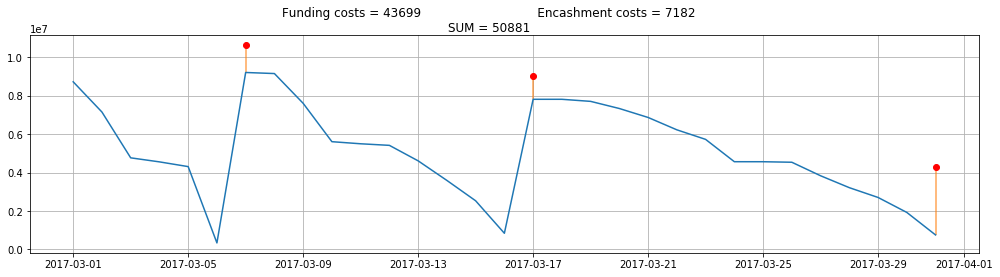

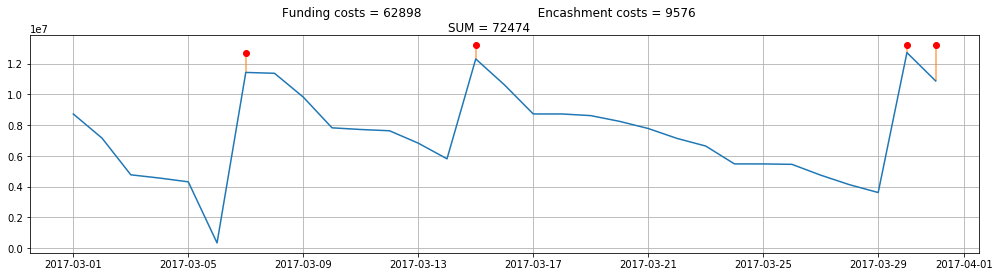

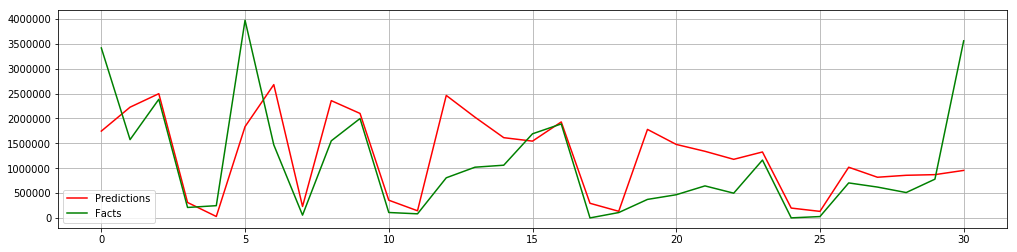

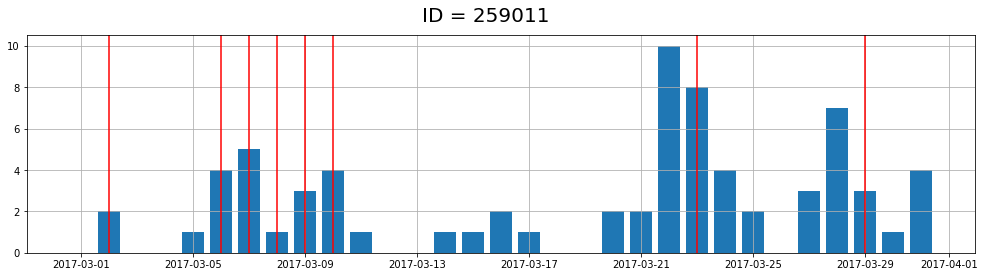

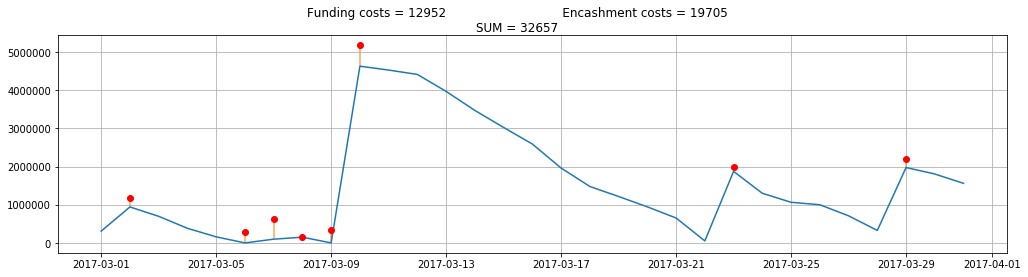

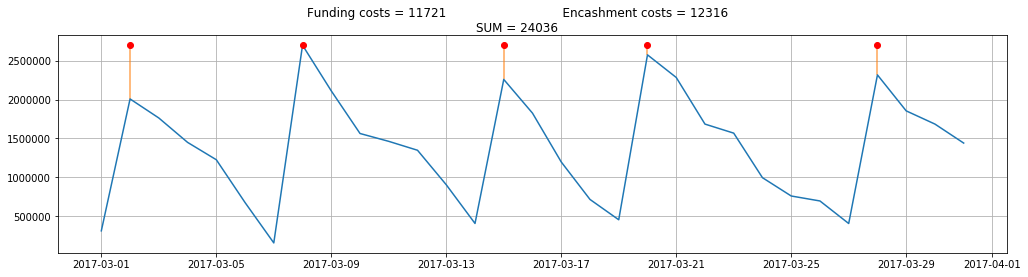

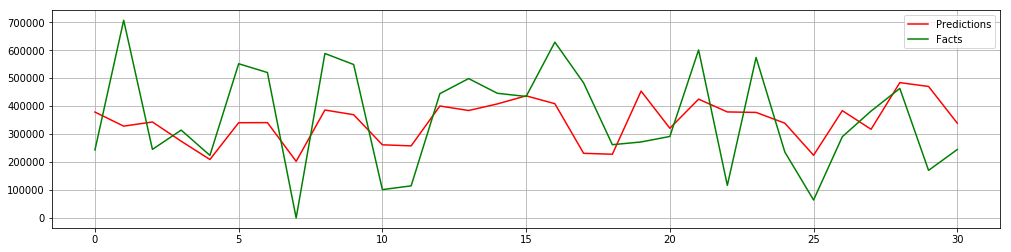

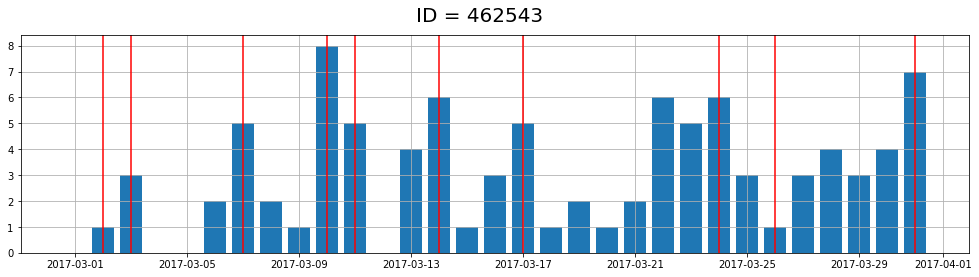

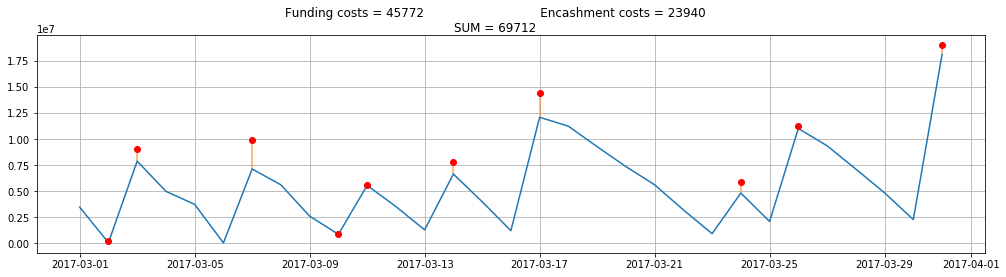

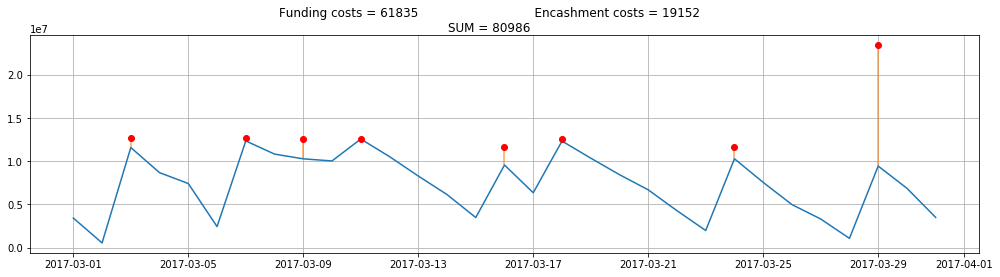

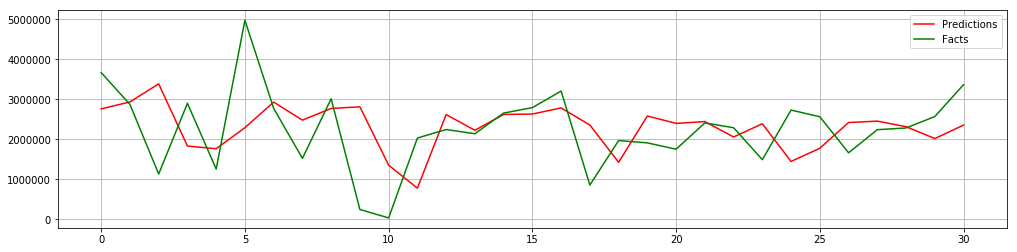

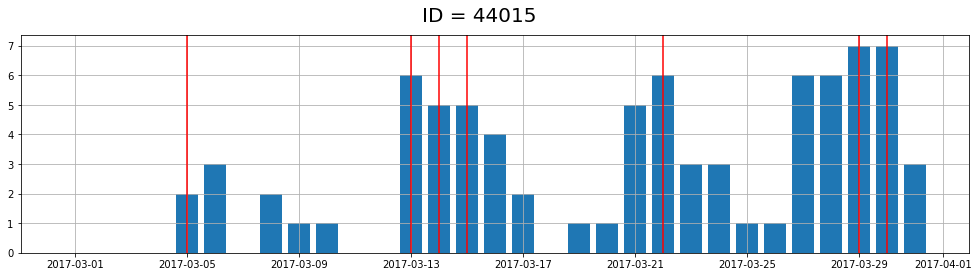

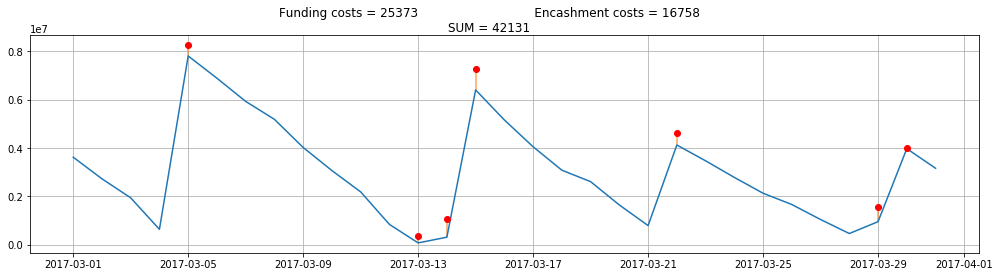

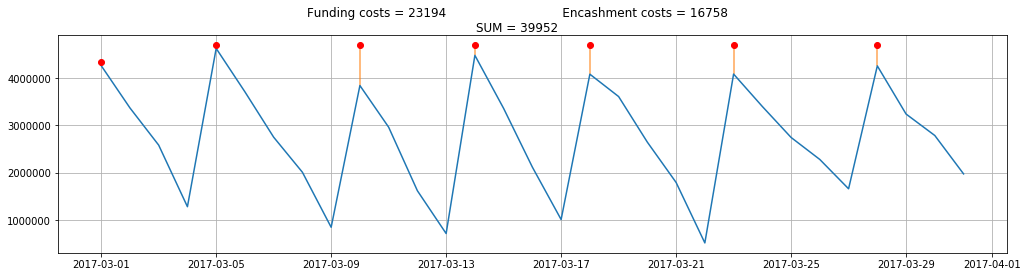

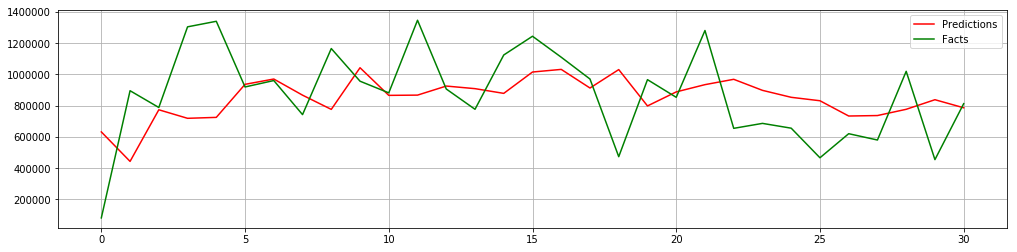

In [32]:
index_gen = pd.date_range(start=pd.to_datetime('2017-03-01'), end=pd.to_datetime('2017-03-31'), freq='D')
for ID in random.sample(range(num_atms), 50):
    if np.max(atm_facts[ID, :]) < 5e6:
        start = deepcopy(pd.to_datetime(global_period[0]))
        end = deepcopy(pd.to_datetime(global_period[0])) + datetime.timedelta(size_window-1)
        tss = []

        for i in range(num_days):
            ts = pd.DataFrame(optimum[i][0][ID, :], index = pd.date_range(start=start, end=end))
            start = start + datetime.timedelta(1)
            end = end + datetime.timedelta(1)
            tss.append(ts)

        tmp = deepcopy(tss[0])
        for i in range(1, len(tss)):
            left, right = deepcopy(tmp.align(tss[i], fill_value = 0))
            tmp = left + right
        tmp = tmp[:'2017-03-31']
    
        plt.figure(figsize = (17,4))
        plt.suptitle('ID = ' + str(L_ATM[ID]), fontsize=20)
        plt.bar(tmp.index, tmp.values.reshape(1, -1)[0])
        pp = pd.Series(patriot_encash_table[ID, :], index = pd.date_range(start=pd.to_datetime('2017-03-01'), end=pd.to_datetime('2017-03-31')))
        ax = plt.axes()
        ymin, ymax = ax.get_ylim()
        ax.vlines(x=pp[pp == 1].index, ymin=ymin, ymax=ymax, color='r')
        ax.set_ylim(ymin, ymax)
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(17,4))
        AAA = np.sum(patriot_funding_costs_table[ID, :])
        BBB = np.sum(patriot_encash_costs_table[ID, :])
        
        plt.suptitle('Funding costs = ' + str(np.ceil(AAA).astype('int64')) + '                             ' +
                     ' Encashment costs = ' + str(np.ceil(BBB).astype('int64')) + '\n' + 
                     'SUM = ' + str(np.ceil(AAA + BBB).astype('int64'))) 
        plt.plot(pd.Series(patriot_losts_table[ID, :], index=index_gen))
        plt.plot(pd.Series(np.where(patriot_encash_table[ID, :] == 1, patriot_load_in_table[ID, :], np.nan), index=index_gen), 'ro')
        plt.vlines(x=index_gen, 
                   ymin=np.where(patriot_encash_table[ID, :] == 1, patriot_losts_table[ID, :], np.nan),
                   ymax = np.where(patriot_encash_table[ID, :] == 1, patriot_load_in_table[ID, :], np.nan), color = 'tab:orange', alpha = 0.7)
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(17,4))
        CCC = np.sum(opticash_funding_costs_table[ID, :])
        DDD = np.sum(opticash_encash_costs_table[ID, :])
        plt.suptitle('Funding costs = ' + str(np.ceil(CCC).astype('int64')) + '                             ' +
                     ' Encashment costs = ' + str(np.ceil(DDD).astype('int64')) + '\n' + 
                     'SUM = ' + str(np.ceil(CCC + DDD).astype('int64'))) 
        plt.plot(pd.Series(opticash_losts_table[ID, :], index=index_gen))
        plt.plot(pd.Series(np.where(opticash_encash_table[ID, :] == 1, opticash_load_in_table[ID, :], np.nan), index=index_gen), 'ro')
        plt.vlines(x=index_gen, 
                   ymin=np.where(opticash_encash_table[ID, :] == 1, opticash_losts_table[ID, :], np.nan),
                   ymax = np.where(opticash_encash_table[ID, :] == 1, opticash_load_in_table[ID, :], np.nan), color = 'tab:orange', alpha = 0.7)
        plt.grid(True)
        plt.show()
        

        plt.figure(figsize=(17,4))
        plt.grid(True)
        plt.plot(atm_predictions[ID, :], 'r', label='Predictions')
        plt.plot(atm_facts[ID,:], 'g', label='Facts')
        plt.legend()
        plt.show()
        print('\n\n\n\n')

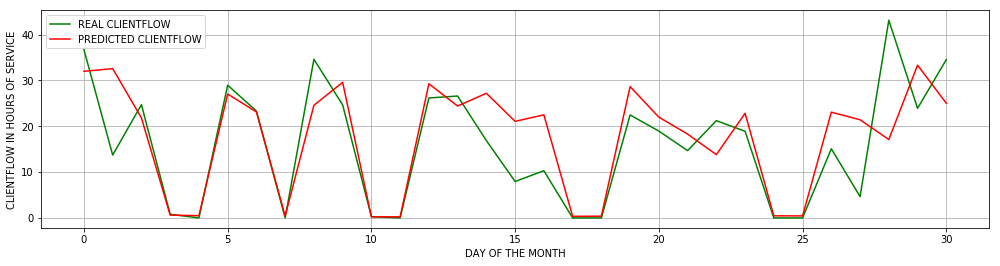

In [33]:
plt.figure(figsize=(17,4))
plt.xlabel('DAY OF THE MONTH')
plt.ylabel('CLIENTFLOW IN HOURS OF SERVICE')
plt.plot(atm_facts[201,:] / 20000, 'g', label='REAL CLIENTFLOW')
plt.plot(atm_predictions[201, :] / 20000, 'r', label='PREDICTED CLIENTFLOW')
plt.legend()
plt.grid(True)
plt.show()

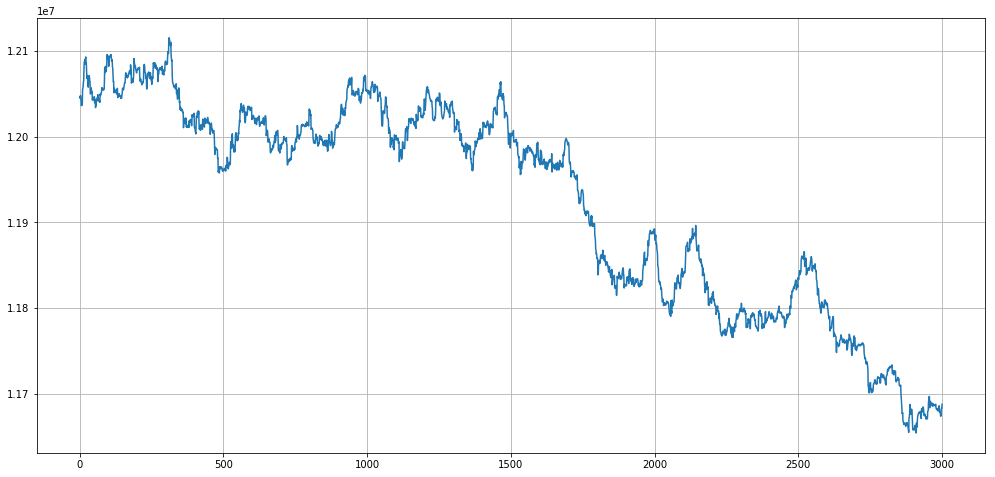

In [34]:
plt.figure(figsize=(17,8))
plt.plot(optimum[0][2][0])
plt.grid(True)

In [35]:
from copy import deepcopy

In [36]:
df = deepcopy(optimum[1][1][0])
for j in range(1,2000):
    df += optimum[1][1][j]
df = df/2000

In [37]:
optimum[1][1][0]

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0]])

In [38]:
import seaborn as sns

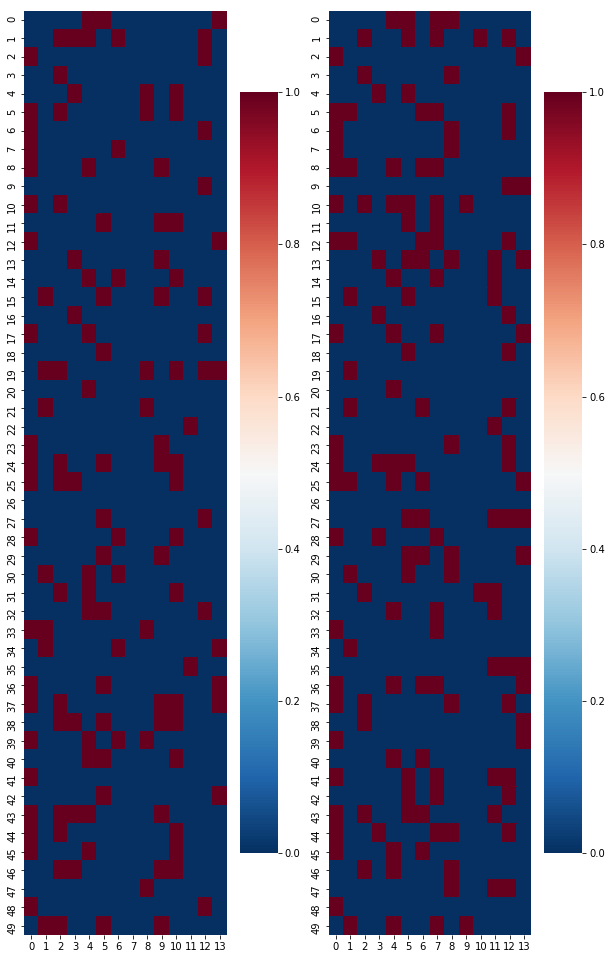

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(optimum[1][1][-1][:50,:], ax = axs[1], cmap='RdBu_r')
plt.show()

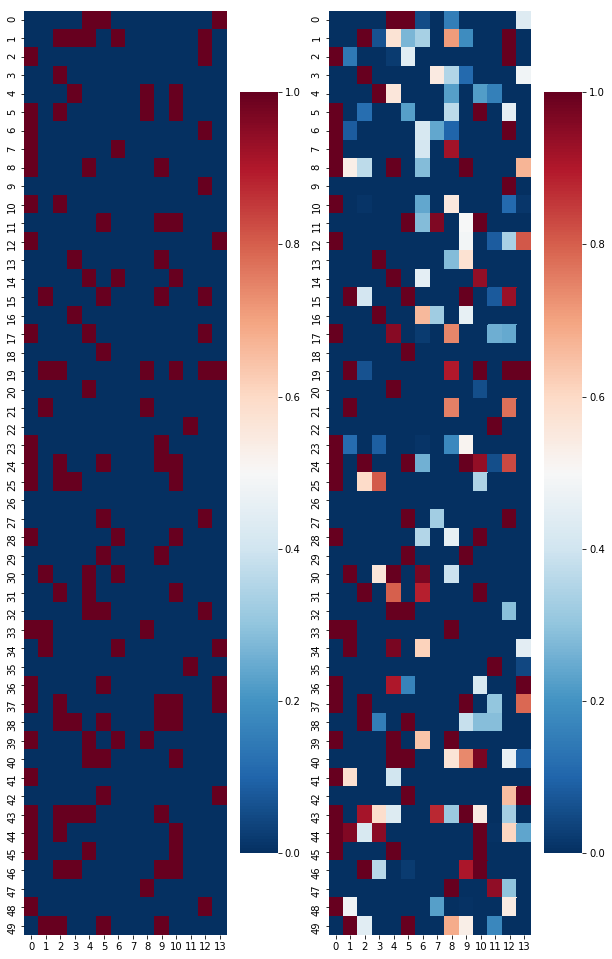

In [40]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(df[:50,:], ax = axs[1], cmap='RdBu_r')
plt.show()

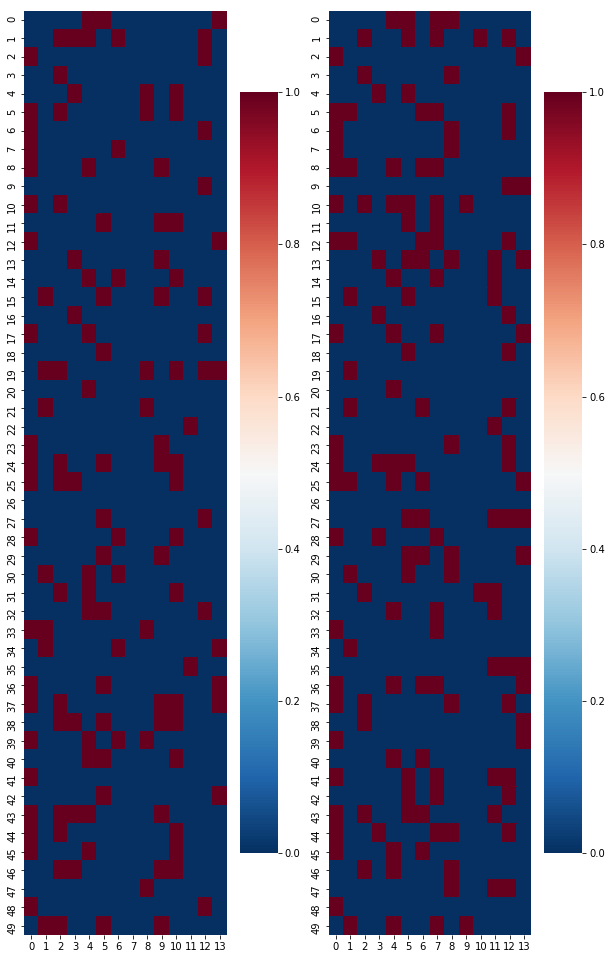

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,17))
sns.heatmap(optimum[1][1][0][:50, :], ax = axs[0], cmap='RdBu_r')
sns.heatmap(optimum[1][1][-1][:50, :], ax = axs[1], cmap='RdBu_r')
plt.show()

# ВДД алгоритм

In [42]:
atm_intraday = pd.read_csv('./data/lecture4/atm_intraday.csv', index_col=0, parse_dates=True)
atm_intraday = atm_intraday.rename(columns={'new_value': 'sum'})
atm_intraday['date_id'] = pd.to_datetime(atm_intraday['date_id'])
atm_intraday['dow'] = atm_intraday['date_id'].dt.weekday
atm_intraday = atm_intraday[atm_intraday.date_id != '2018-01-13']
atm_intraday.index = range(atm_intraday.shape[0])
atm_intraday['new_sum'] = np.where(atm_intraday['sum'] < 0, 0, atm_intraday['sum'])

In [43]:
list_ids = L_ATM
n_ids = num_atms
dia = atm_intraday[atm_intraday.ATM_ID.isin(list_ids)]

dia = dia.sort_values(['ATM_ID', 'dow', 'hour'])

dia_each = dia.groupby(by=['ATM_ID', 'dow', 'hour'])['new_sum'].mean().reset_index()
dia_each.index = range(dia_each.shape[0])

for _id in list_ids:
    if _id not in dia_each.ATM_ID.unique():
        print('There is not intraday data for ID = ' + str(_id) + ', type = ' + 'atm' + '\n' +
              'The intraday distribution was set as mean for all ' + 'atm' + 's')

A1 = []
for i_id in range(n_ids):
    A2 = []
    for i_dow in range(7):
        d_app = np.array(dia_each[(dia_each.ATM_ID == list_ids[i_id]) & (dia_each.dow == i_dow)]['new_sum'])
        if len(d_app) == 24 and np.all(d_app != np.inf):
            A2.append(list(np.ceil(d_app)))
        else:
            A2.append([0] * 24)
    A1.append(A2)
A1 = np.array(A1)

for i_id in range(n_ids):
    for i_dow in range(7):
        sum_day = np.sum(A1[i_id, i_dow])
        if sum_day != 0:
            A1[i_id, i_dow] = A1[i_id, i_dow] / sum_day
        else:
            A1[i_id, i_dow] = np.array([0] * 24)

dia_all = dia.groupby(by=['dow', 'hour'])['new_sum'].mean().reset_index()
dia_all.index = range(dia_all.shape[0])
A2 = []
for i_dow in range(7):
    d_app = np.array(dia_all[dia_all.dow == i_dow]['new_sum'])
    if len(d_app) == 24 and np.all(d_app != np.inf):
        A2.append(list(np.ceil(d_app)))
    else:
        A2.append([0] * 9 + [1] * 12 + [0] * 3)
A2 = np.array(A2)

for i_dow in range(7):
    sum_day = np.sum(A2[i_dow])
    if sum_day != 0:
        A2[i_dow] = A2[i_dow] / sum_day
    else:
        A2[i_dow] = np.array([0.0] * 9 + [1/12] * 12 + [0.0] * 3)

for i in range(n_ids):
    for j in range(7):
        if np.sum(A1[i, j]) < 0.1:
            A1[i, j] = A2[j].copy()
        m1, arg_m1 = np.max(A1[i, j]), np.argmax(A1[i, j])
        A1[i, j, arg_m1] = 1000
        for k in range(24):
            if k != arg_m1:
                A1[i, j, k] = np.ceil(A1[i, j, k] * 1000)
                A1[i, j, arg_m1] -= A1[i, j, k]

dist_list = A1 / 1000

There is not intraday data for ID = 352546, type = atm
The intraday distribution was set as mean for all atms


In [44]:
dia

date_id  hour  DISPENCED_TOTAL    ATM_ID      sum  dow  new_sum
59      2017-11-27     0           2600.0     10087      0.0    0      0.0
430     2017-12-18     0        1553400.0     10087      0.0    0      0.0
590     2017-12-25     0        7014500.0     10087  11000.0    0  11000.0
803     2018-01-08     0        6851800.0     10087    200.0    0    200.0
939     2018-01-15     0        5752100.0     10087  40600.0    0  40600.0
...            ...   ...              ...       ...      ...  ...      ...
5644089 2017-12-17    23         974500.0  10208203      0.0    6      0.0
5644249 2017-12-24    23        2263400.0  10208203      0.0    6      0.0
5644462 2018-01-07    23        1651800.0  10208203      0.0    6      0.0
5644598 2018-01-14    23        3054200.0  10208203      0.0    6      0.0
5644766 2018-01-21    23        1484500.0  10208203      0.0    6      0.0

[677688 rows x 7 columns]

In [45]:
dia[(dia.ATM_ID == list_ids[0]) & (dia.dow == 6) & (dia.date_id == '2017-11-26')]

date_id  hour  DISPENCED_TOTAL  ATM_ID  sum  dow  new_sum
35 2017-11-26     0           2600.0   10087  0.0    6      0.0
36 2017-11-26     1           2600.0   10087  0.0    6      0.0
37 2017-11-26     2           2600.0   10087  0.0    6      0.0
38 2017-11-26     3           2600.0   10087  0.0    6      0.0
39 2017-11-26     4           2600.0   10087  0.0    6      0.0
40 2017-11-26     5           2600.0   10087  0.0    6      0.0
41 2017-11-26     6           2600.0   10087  0.0    6      0.0
42 2017-11-26     7           2600.0   10087  0.0    6      0.0
43 2017-11-26     8           2600.0   10087  0.0    6      0.0
44 2017-11-26     9           2600.0   10087  0.0    6      0.0
45 2017-11-26    10           2600.0   10087  0.0    6      0.0
46 2017-11-26    11           2600.0   10087  0.0    6      0.0
47 2017-11-26    12           2600.0   10087  0.0    6      0.0
48 2017-11-26    13           2600.0   10087  0.0    6      0.0
49 2017-11-26    14           2600.0   10087  0.0    6      0.0
50 2017-11-26    15           2600.0   10087  0.0    6      0.0
51 2017-11-26    16           2600.0   10087  0.0    6      0.0
52 2017-11-26    17           2600.0   10087  0.0    6      0.0
53 2017-11-26    18           2600.0   10087  0.0    6      0.0
54 2017-11-26    19           2600.0   10087  0.0    6      0.0
55 2017-11-26    20           2600.0   10087  0.0    6      0.0
56 2017-11-26    21           2600.0   10087  0.0    6      0.0
57 2017-11-26    22           2600.0   10087  0.0    6      0.0
58 2017-11-26    23           2600.0   10087  0.0    6      0.0

ID = 10087


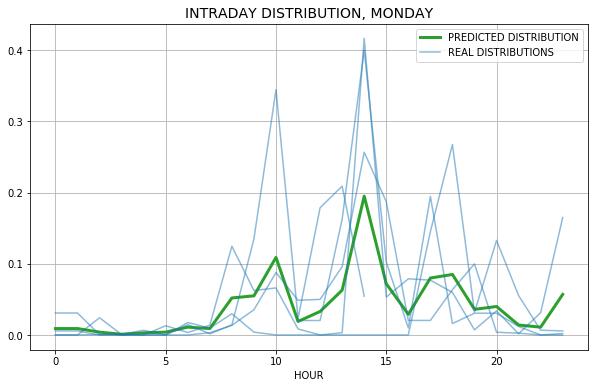

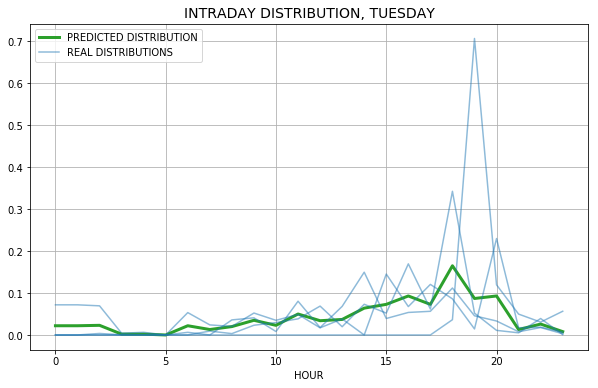

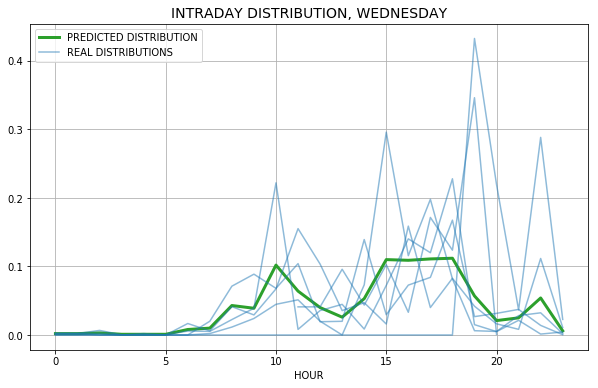

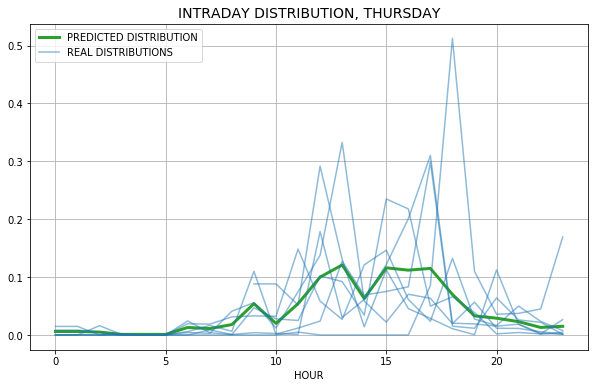

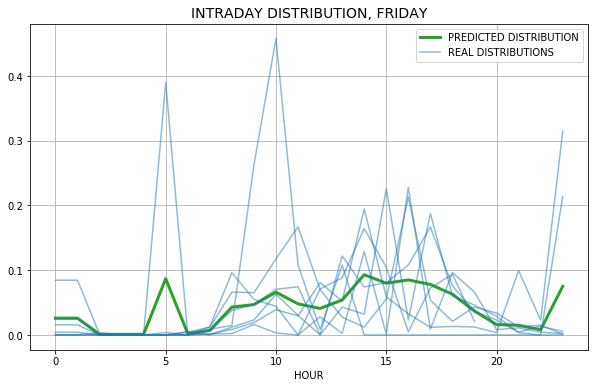

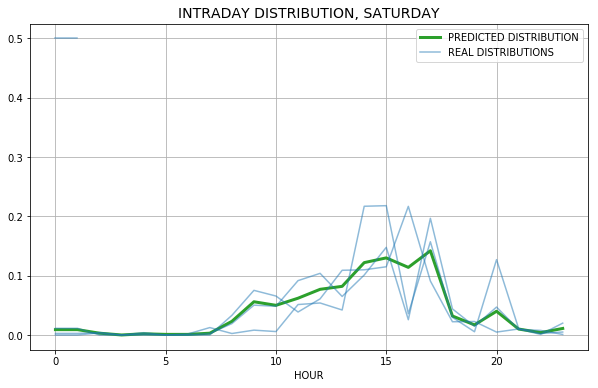

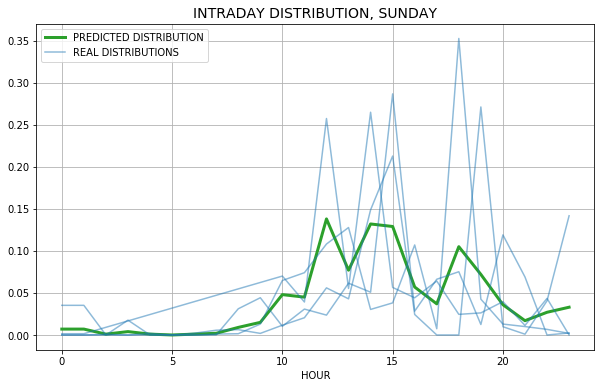

In [46]:
weekdays = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']

I_ID = 0

print('ID = ' + str(list_ids[I_ID]))

for dow in range(7):
    plt.figure(figsize=(10,6))
    plt.title('INTRADAY DISTRIBUTION, ' + weekdays[dow], fontsize=14)
    plt.plot(dist_list[I_ID][dow], color='tab:green', linewidth=3.0, label='PREDICTED DISTRIBUTION')
    poss_dates = dia[dia.dow == dow].date_id.unique()
    for mm, datt in enumerate(poss_dates):
        df_dia = dia[(dia.ATM_ID == list_ids[I_ID]) & (dia.date_id == datt)].sort_values('hour')
        sum_d = np.sum(df_dia['new_sum'])
        if mm == 0:
            plt.plot(df_dia['hour'], np.array(df_dia['new_sum']) / sum_d, color='tab:blue', alpha=0.5, label='REAL DISTRIBUTIONS')
        else:
            plt.plot(df_dia['hour'], np.array(df_dia['new_sum']) / sum_d, color='tab:blue', alpha=0.5)
    plt.legend()
    plt.grid(True)
    plt.xlabel('HOUR')
    plt.show()

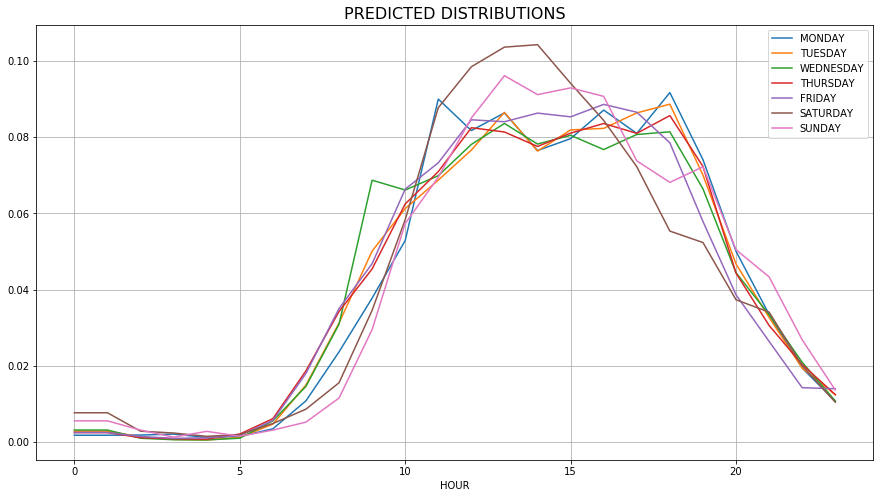

In [47]:
plt.figure(figsize=(15,8))
plt.title('PREDICTED DISTRIBUTIONS', fontsize=16)
for dw in range(7):
    plt.plot(range(24), dia_all[dia_all.dow == dw]['new_sum'] / np.sum(dia_all[dia_all.dow == dw]['new_sum']), label=weekdays[dw])
plt.xlabel('HOUR')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
dia.head(10)

date_id  hour  DISPENCED_TOTAL  ATM_ID      sum  dow  new_sum
59   2017-11-27     0           2600.0   10087      0.0    0      0.0
430  2017-12-18     0        1553400.0   10087      0.0    0      0.0
590  2017-12-25     0        7014500.0   10087  11000.0    0  11000.0
803  2018-01-08     0        6851800.0   10087    200.0    0    200.0
939  2018-01-15     0        5752100.0   10087  40600.0    0  40600.0
1107 2018-01-22     0        7713500.0   10087      0.0    0      0.0
60   2017-11-27     1           2600.0   10087      0.0    0      0.0
431  2017-12-18     1        1553400.0   10087      0.0    0      0.0
591  2017-12-25     1        7025500.0   10087  11000.0    0  11000.0
804  2018-01-08     1        6852000.0   10087    200.0    0    200.0

In [49]:
dia_each.head(20)

ATM_ID  dow  hour        new_sum
0    10087    0     0    8633.333333
1    10087    0     1    8633.333333
2    10087    0     2    3850.000000
3    10087    0     3     620.000000
4    10087    0     4    2080.000000
5    10087    0     5    3400.000000
6    10087    0     6   10300.000000
7    10087    0     7    8680.000000
8    10087    0     8   51180.000000
9    10087    0     9   53240.000000
10   10087    0    10  106480.000000
11   10087    0    11   18200.000000
12   10087    0    12   32100.000000
13   10087    0    13   61650.000000
14   10087    0    14  204050.000000
15   10087    0    15   70557.142857
16   10087    0    16   27857.142857
17   10087    0    17   78828.571429
18   10087    0    18   83400.000000
19   10087    0    19   34600.000000

In [50]:
dia_all

dow  hour        new_sum
0      0     0    2304.083885
1      0     1    2304.083885
2      0     2    2377.649007
3      0     3    2691.026490
4      0     4    1537.350993
5      0     5    1918.708609
6      0     6    4512.483444
7      0     7   14111.291391
8      0     8   30933.112583
9      0     9   49373.708609
10     0    10   69147.847682
11     0    11  117706.977294
12     0    12  106897.847682
13     0    13  112953.663079
14     0    14  100035.823675
15     0    15  104124.101230
16     0    16  113922.421949
17     0    17  105922.965941
18     0    18  119927.365184
19     0    19   96914.664144
20     0    20   65453.571429
21     0    21   43754.824976
22     0    22   25363.859981
23     0    23   13965.121413
24     1     0    4164.183223
25     1     1    4164.183223
26     1     2    1979.718543
27     1     3     965.093819
28     1     4     738.438190
29     1     5    1741.363135
30     1     6    6857.091611
31     1     7   21916.749448
32     1     8   45763.852097
33     1     9   73471.712394
34     1    10   89824.905393
35     1    11  100784.720908
36     1    12  112347.989593
37     1    13  126849.053926
38     1    14  111954.919584
39     1    15  120091.745506
40     1    16  120693.519395
41     1    17  126646.310312
42     1    18  130006.338694
43     1    19  102739.640492
44     1    20   68485.856197
45     1    21   47920.151372
46     1    22   28433.159886
47     1    23   18151.537370
48     2     0    4677.932829
49     2     1    4677.932829
50     2     2    1448.084201
51     2     3     878.689688
52     2     4     799.199779
53     2     5    1466.854305
54     2     6    8247.417219
55     2     7   21789.536424
56     2     8   46138.079470
57     2     9  102549.763482
58     2    10   98708.065279
59     2    11  104319.764073
60     2    12  116578.952815
61     2    13  124774.089404
62     2    14  116719.495033
63     2    15  120139.631623
64     2    16  114562.603477
65     2    17  120458.961093
66     2    18  121512.769040
67     2    19   99182.284768
68     2    20   66288.265728
69     2    21   49809.649953
70     2    22   31213.978240
71     2    23   16058.420057
72     3     0    3583.609272
73     3     1    3583.609272
74     3     2    1631.433302
75     3     3    1235.052034
76     3     4    1046.688742
77     3     5    3023.580889
78     3     6    8887.701041
79     3     7   27165.279092
80     3     8   49817.029328
81     3     9   66082.098510
82     3    10   90902.400662
83     3    11  103256.022351
84     3    12  120017.591060
85     3    13  118384.478477
86     3    14  112866.825331
87     3    15  117949.937914
88     3    16  121634.416391
89     3    17  117875.331126
90     3    18  124645.819536
91     3    19  105250.000000
92     3    20   64465.459437
93     3    21   44470.033113
94     3    22   29573.592715
95     3    23   18091.225166
96     4     0    3932.740066
97     4     1    3932.740066
98     4     2    2235.140728
99     4     3    1506.829470
100    4     4    1702.028146
101    4     5    2696.937086
102    4     6    8945.219371
103    4     7   28472.909768
104    4     8   55420.633278
105    4     9   74062.396523
106    4    10  105031.001656
107    4    11  115964.879967
108    4    12  133847.123344
109    4    13  133040.378955
110    4    14  136621.780721
111    4    15  135074.981604
112    4    16  140252.796174
113    4    17  136986.791759
114    4    18  124288.097866
115    4    19   91608.149375
116    4    20   61125.413907
117    4    21   41775.682947
118    4    22   22546.150662
119    4    23   22110.099338
120    5     0    6199.034216
121    5     1    6199.034216
122    5     2    2281.390728
123    5     3    1895.662252
124    5     4    1193.841060
125    5     5    1558.443709
126    5     6    3918.476821
127    5     7    6963.211921
128    5     8   12568.278146
129    5     9   27954.536424
130    5    10   47205.629139
131    5    11   70990.066225
132    5    12 